still have some inconsistencies in municipality names:

* brock
* caledon
* georgina
* st george
* hamilton
* Sault Ste Marie
* markham
* toronto
* cavan
* elmvale
* grand valley
* whitchurch-stouville (erase spaces)
* keep mississaugas of the scugog island
* north york

<a id='top'></a>
# Teranet dataset -- Part 1: Data cleaning v0.9
---
Version history

v0.9 -- first release of Part 1: Data cleaning to everyone involved in working with the Teranet dataset.

---
#### This document presents Part 1 of the workflow on the Teranet dataset -- the cleanup process.

This document can be viewed as a report or can be run as a script, replicating the full cleanup process of the Teranet dataset and producing a new cleaned file.

> If you want to run the script, you need to open the `'Teranet_data_cleaning.ipynb'` file in Jupyter on your computer. You will also need to make sure that the `'HHSaleHistory.csv'` file is located in the subfolder /Data/ relative from the location of the script file (`'Teranet_data_cleaning.ipynb'`) on your computer, or correct the file paths in [step 1.1](#load_dataset) and [step 1.9](#record_results). After that has been done, you can simply select Cell -> Run All in the opened Jupyter botebook `'Teranet_data_cleaning.ipynb'`, after all scripts are executed, a new file `'HHSaleHistory_cleaned_v0.9.csv'` will appear in the subdirectory /Data/ (it will take some time to execute all the scripts). No changes are made to the original file.

Author: [Stepan Oskin](https://www.linkedin.com/in/stepan-oskin-871b8a65/)   
        E-mail: stepan.oskin@mail.utoronto.ca   
        (feel free to contact with questions, any suggestions/corrections are welcome)

[Table of contents](#contents)


## Summary


The following modifications have been made to the dataset:


* capitalizations were fixed for column names, and values in columns `'municipality'`, `'street name'`, and `'street_designation'`. Observed`'postal_code'` values did not show any problems, but the column was converted to upper case  as a preventive measure to ensure consistency.


* 5 duplicate checks using different criteria for detection have been performed, results summarized. More checks have been performed, the 5 presented are the most meaningful ones.


* **813'138 duplicate entries** that match in everything but the `'pin'` **have been removed from the dataset**. 

    * This eliminates 83'798 duplicate records identical in everything, including `'pin'`, 
    * and 729'182 additional entries identical in everything, but the `'pin'`. 
    * These records represent one transaction being recorded under several entries using different `'pin'`s (one row for the house, one for the parking lot, etc.). 
    * `'consideration_amt'` in this case is duplicated, with each record showing the total price of the transaction, so these 729'182 records are also considered duplicated and are removed from the dataset.
    * After 813'138 duplicate entries (9% of the total) have been removed from the dataset, there are **8'226'103 unique rows remaining.**


* `'registration_date'` has been converted to Pandas datetime format (Pandas is a Python library used for data processing): YYYY-MM-DD 00:00:00.


* Columns `'year'` and `'decade'` have been added to the dataset for data grouping and visualization (parsed from `'registration_date'`).


* Dataset has been reindexed and resorted by `'registration_date'`


* New column `'row_num'` was added. Numbers of rows in `'row_num'` go in the order from earliest date in the dataset to the latest. 


* `'row_num'` column presents the only unique row identifier in Teranet dataset, as all the other columns have duplicate values in them (even after duplicate rows are removed), including `'registration_date'`, `'pin'`, and `coordinates`. **Therefore, currently `'row_num'` is the only column in the dataset that can be used as a _primary key_** in the context of a normalized database (see [step 1.0](#data_cleaning)).


* **All values of `'consideration_amt'` below 30 dollars have been reset to NaN (missing values)**. These records represent missing values and gift transactions, they have not been removed from the dataset, but their `'consideration_amt'` has been reset to NaN to exclude them from statistical operations.


* There is an unreasonably high number of NaN values in the column `'consideration_amt'` (missing or under 30 dollars) for records from 1950s to 1970s (especially 1970s). See [step 1.7](#price_nan)


* **Consistency of entries in all columns have been verified.**

    * Erratic entries have been fixed in columns `'registration_date'`, `'province'`, `'unitno'`, `'street_designation'`, `'street_direction'` and `'municipality'`.
    * Erratic entries remain present in the column `'street_name'`, their correction presents a time-intensive task if performed for the whole dataset. Instead, targeted clean-up can be done in the future for particular streets, if such need arises. 


* Results have been saved to a new file: `'Data/HHSaleHistory_cleaned_v0.9.csv'`

<a id='contents'></a>
#### Table of contents:

1.0 [Data cleaning](#data_cleaning)

1.1 [Import libraries](#import_libraries)
    
1.2 [Load the full dataset](#load_dataset)
    
1.3 [Improper capitalizations](#capitalizations)
    
1.4 [Data types](#data_types)

1.5 [Duplicate checks](#duplicate_checks)
    
1.6 [Datetime conversion](#datetime_conversion)
    
1.7 [Missing values](#missing_values)

1.8 [Consistency of entries](#inconsistent_entries)

1.9 [Recording results to a file](#record_results)

1.10 [References](#references)

<a id='data_cleaning'></a>
# 1.0 Data cleaning

Back to the [top](#top) / [table of contents](#contents)
 
### 1.0.1 Tidy data

Hadley Wickham in his paper "Tidy Data" [(Wickham, 2014)](#wickham_2014) formalized the way how a shape of the data can be described and what goal should be pursued when formatting data. The principles of _tidy data_ provide a standard way to organize data values within a dataset. The _tidy data_ standard has been designed to facilitate initial exploration and analysis of the data, and to simplify the development of data analysis tools that work well together. The principles of _tidy data_ are closely tied to those of relational databases and Codd’s relational algebra [(Codd 1990)](#codd_1990).

As an integral part of his [relational model](https://en.wikipedia.org/wiki/Relational_model), Codd proposed a process of database normalization, or restructuring of a relational database in accordance with a series of so-called [normal forms](https://en.wikipedia.org/wiki/Database_normalization#Normal_forms) in order to reduce data redundancy and improve data integrity.

### 1.0.2 Normalization of a database according to Codd

Normalization entails organizing the columns (attributes) and tables (relations) of a database to ensure that their dependencies are properly enforced by database integrity constraints. As defined by Codd ([1990](#codd_1990), section 17.5.1), the basic ideas in normalization are to organize the information in a database as follows: 

1. Each distinct type of object has a distinct type identifier, which becomes the name of a base relation.


2. Every distinct object of a given type must have an instance identifier that is unique within the object type; this is called its _primary-key value_.


3. Every fact in the database is a fact about the object identified by the _primary key_.


4. Each such fact contains nothing other than the single-valued immediate properties of the object.


5. Such facts are collected together in a single relation, if they are about objects of the same type. The result is a collection of facts, all of the same type. 

### 1.0.3 Teranet dataset in the context of a normalized database

Teranet dataset can be viewed as one of the datasets of a housing database that would include other sources of information (tables),  such as neighbourhood demographics, building types and coordinates, _etc._ In this context, Codd's basic normalization ideas would take the following form:

1. The Teranet dataset presents a single type of object (relation, or table) -- **real estate transactions** recorded in the Province of Ontario between 1805-01-06 and 2017-10-11.


2. Every distinct object (transaction) must have an instance identifier that is **unique within the object type**, or its _primary-key value_. In case of Teranet dataset, the **only unique instance identifier** (column) is the **new inserted column `'row_num'`** (see [step 1.6](#datetime_conversion)) that corresponds to the row number of each instance (transaction) in the cleaned dataset, ordered from the earliest date to the latest. All the other columns, including `'registration_date'`, `'pin'`, `address` inormation, and `coordinates`, have duplicated values in them (multiple transactions occuring on the same date, address, coordinates, or under the same pin, see [step 1.8](#inconsistent_entries)) and, thus, cannot be used as _primary-key values_.


3. Every fact in the database is a fact about the object identified by the _primary key_. This condition is met, as every transaction in Teranet dataset is described by the values found in columns of a single row (after duplicate rows are removed, see [step 1.6](#duplicate_checks)).


4. Each such fact contains nothing other than the single-valued immediate properties of the object, all columns in Teranet dataset contain single-valued immediate properties of each transaction.


5. Such facts are collected together in a single relation, as they are all objects of the same type (a single table of real estate transactions recorded in Ontario).

Thus, **Teranet dataset fits into a normalized database**, with row numbers (or values of `'row_num'`) as its _primary keys_. Therefore, **it can be merged with other sources of data** (such as a dataset of buildings with corresponding coordinates, address information, zoning, neighbourhood demographics, _etc._) using `'row_num'`, or row numbers, as unique identifier of instances (transactions).

### 1.0.4 Codd's constraints formed in statistical language by Wickham

According to Wickham [(2014)](#wickham_2014), _tidy data_ is a standard way of mapping the meaning of a dataset to its structure. A dataset is messy or tidy depending on how rows, columns and tables are matched up with observations,
variables and types. In _tidy data:_
1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.


This is Codd’s 3rd normal form [(Codd, 1990)](#codd_1990), but with the constraints framed in statistical
language, and the focus put on a single dataset rather than the many connected datasets
common in relational databases. _Messy data_ is any other arrangement of the data.


According to Wickham [(2014)](#wickham_2014), the most common problems with messy datasets are:
* Column headers are values, not variable names.
* Multiple variables are stored in one column.
* Variables are stored in both rows and columns.
* Multiple types of observational units are stored in the same table.
* A single observational unit is stored in multiple tables.


In Teranet dataset, none of these problems are present, so it presents _tidy data._


### 1.0.5 Other common data problems may include:

● **Inconsistent column names** (see [step 1.3](#capitalizations))

Column names can have inconsistent capitalizations and/or bad characters.


● **Missing data** (see [step 1.7](#missing_values))

Missing data needs to be identified and addressed.


● **Outliers** (will be investigated in **Part 2: Exploratory Data Analysis**)

Outliers can pose a potential problem and need to be investigated.


● **Duplicate rows** (see [step 1.5](#duplicate_checks))

Duplicate rows can bias analysis and need to be found and dropped.


● **Untidy** (see [step 1.8](#inconsistent_entries))

Untidy datasets can contain multiple problems, and prevent us from quickly transforming our dataset from one suitable for reporting to a dataset suitable for analysis.


● **Need to process columns** (see [step 1.6](#datetime_conversion))

Columns might need to be processed before they can be used for data analysis.


● **Column types can signal unexpected data values** (see [step 1.4](#data_types))

Column types can signal the presence of unexpected data values.


<a id='import_libraries'></a>
## 1.1 Import libraries

Back to the [top](#top) / [table of contents](#contents)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import inf

%matplotlib inline

print("Libraries successfully imported!")

Libraries successfully imported!


#### Configure a plot for future use

In [2]:
# Set some parameters to apply to all plots. These can be overridden
# in each plot if desired
import matplotlib
# Plot size to 14" x 7"
matplotlib.rc('figure', figsize = (14, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

<a id='load_dataset'></a>
## 1.2 Load the full dataset

Back to the [top](#top) / [table of contents](#contents)

The full dataset is read into data frame `'data'` from the `''Data/HHSaleHistory.csv'` file.

**If running this script, check that the path to file is correct** (relative from the location of the script -- .ipymb file)

In [3]:
file = 'Data/HHSaleHistory.csv'             # check the file path here

data = pd.read_csv(file, low_memory=False, na_values=' ')
                                                                # read the .csv file into data frame 'data',
                                                                # low_memory=False ensures better data type detection
                                                                # na_values are set to ' ' (empty space)
                        # 'registration_date' would not be parsed correctly when reading, see step 1.6
print("The full original Teranet dataset"
      "contains {0:,} rows and {1} columns"
      .format(data.shape[0], data.shape[1]))

Full file read successfully to data frame 'data'!


Total number of entries: 9039241


`'registration_date'` will be parsed in [step 1.6](#datetime_conversion)

<a id='capitalizations'></a>
## 1.3 Improper capitalizations

Back to the [top](#top) / [table of contents](#contents)

* [Column names](#column_names_cap) have inconsistent capitalizations.

* Values in [`'street_name'`, `'street_designation'`](#str_nam_des_cap) and [`'municipality'`](#mun_cap) have inconsistent capitalizations.

* Values in [`'postal_code'`](#postal_code_cap) do not show problems, but have been converted to upper case simply to be sure they are all properly capitalized.

<a id='column_names_cap'></a>
### 1.3.1 Column names capitalization

Back to the [top](#top) / [table of contents](#contents)

Back to [step 1.3](#capitalizations)

Column names have inconsistent capitalizations:

In [4]:
data.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y'],
      dtype='object')

#### Converting columns names to lower case

In [5]:
data.columns = data.columns.str.lower()
print("Column names converted to lower case! Column names:")
list(data.columns)

Column names converted to lower case! Column names:


['lro_num',
 'pin',
 'consideration_amt',
 'registration_date',
 'postal_code',
 'province',
 'unitno',
 'street_name',
 'street_designation',
 'street_direction',
 'municipality',
 'street_suffix',
 'street_number',
 'x',
 'y']

All column names have been converted to lower case. There appears to be no empty spaces in column names.
<a id='mun_cap'></a>
### 1.3.2 Capitalizing `'municipality'`

Back to the [top](#top) / [table of contents](#contents)

Back to [step 1.3](#capitalizations)

Inconsistent capitalizations are present in the column `'municipality'`.

#### Sample of inconsistent capitalizations:

In [6]:
# sample of entries with 'municipality' value 'TORONTO'
mask = data['municipality'] == 'TORONTO'
print("First 5 entries with 'municipality' value 'TORONTO':\n")
print(data.loc[mask, 'municipality'].head())

# sample of entries with 'municipality' value 'Toronto'
mask = data['municipality'] == 'Toronto'
print("\n\nFirst 5 entries with 'municipality' value 'Toronto':\n")
print(data.loc[mask, 'municipality'].head())

First 5 entries with 'municipality' value 'TORONTO':

0         TORONTO
105672    TORONTO
110020    TORONTO
111389    TORONTO
112888    TORONTO
Name: municipality, dtype: object


First 5 entries with 'municipality' value 'Toronto':

152629    Toronto
152633    Toronto
152634    Toronto
152635    Toronto
155175    Toronto
Name: municipality, dtype: object


#### Capitalizing strings in `'municipality'`

In [7]:
# capitalize the strings in 'municipality' in data frame 'data'
data.loc[:, 'municipality'] = data.loc[:, 'municipality'].str.title()
print("Strings in 'municipality' have been successfully capitalized! Updated in data frame 'data'.")

Strings in 'municipality' have been successfully capitalized! Updated in data frame 'data'.


#### Verification of result

In [8]:
# sample of entries with 'municipality' value 'TORONTO'
mask = data['municipality'] == 'TORONTO'
print("First 5 entries with 'municipality' value 'TORONTO':\n")
print(data.loc[mask, 'municipality'].head())

# sample of entries with 'municipality' value 'Toronto'
mask = data['municipality'] == 'Toronto'
print("\n\nFirst 5 entries with 'municipality' value 'Toronto':\n")
print(data.loc[mask, 'municipality'].head())

First 5 entries with 'municipality' value 'TORONTO':

Series([], Name: municipality, dtype: object)


First 5 entries with 'municipality' value 'Toronto':

0         Toronto
105672    Toronto
110020    Toronto
111389    Toronto
112888    Toronto
Name: municipality, dtype: object


The first subset (entries with `'municipality'` value 'TORONTO') displays an empty series, capitalizations in `'municipality'` have been fixed in the data frame `'data'`.
<a id='str_nam_des_cap'></a>
### 1.3.3 Capitalizing `'street_name'` and `'street_designation'`

Back to the [top](#top) / [table of contents](#contents)

Back to [step 1.3](#capitalizations)

Improper capitalizations are present in columns `'street_name'` and `'street_desigantion'`.

#### Sample of improper capitalizations

In [9]:
# subset records with non-null values of 'street_name' and 'street_designation'
mask = np.logical_and(data.loc[:, 'street_name'].notnull(), data.loc[:, 'street_designation'].notnull())
data.loc[mask].head()             # display the top 5 rows of the subset

,lro_num,pin,consideration_amt,registration_date,postal_code,province,unitno,street_name,street_designation,street_direction,municipality,street_suffix,street_number,x,y
1,58,231690123,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,BLUE SPRINGS,DR,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
2,58,231690365,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,BLUE SPRINGS,DR,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
3,58,231690246,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,BLUE SPRINGS,DR,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
7,58,226130326,152800.0,7/13/1989 0:00:00,N2E2K9,ON,NaN,COUNTRY HILL,DR,NaN,Kitchener,NaN,370.0,-80.466845,43.410641
8,58,231330013,157900.0,7/13/1989 0:00:00,N2V1Z3,ON,13.0,BENJAMIN,RD,NaN,Waterloo,NaN,225.0,-80.558966,43.503090


#### Capitalizing entries in `'street_name'` and `'street_designation'`

In [10]:
# capitalize first letter of each word in 'street_name'
data.loc[:, 'street_name'] = data.loc[:, 'street_name'].str.title()
print("\nStrings in 'street_name' have been successfully capitalized!")

# capitalize 'street_designation'
data.loc[:, 'street_designation'] = data.loc[:, 'street_designation'].str.capitalize()
print("\nStrings in 'street_designation' have been successfully capitalized!")


Strings in 'street_name' have been successfully capitalized!

Strings in 'street_designation' have been successfully capitalized!


#### Verification of results

In [11]:
# subset records with non-null values of 'street_name' and 'street_designation'
mask = np.logical_and(data.loc[:, 'street_name'].notnull(), data.loc[:, 'street_designation'].notnull())

# display the top 5 rows of the subset
data.loc[mask].head()

,lro_num,pin,consideration_amt,registration_date,postal_code,province,unitno,street_name,street_designation,street_direction,municipality,street_suffix,street_number,x,y
1,58,231690123,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,Blue Springs,Dr,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
2,58,231690365,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,Blue Springs,Dr,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
3,58,231690246,95000.0,11/27/1995 0:00:00,N2J4T2,ON,602.0,Blue Springs,Dr,NaN,Waterloo,NaN,30.0,-80.525982,43.488896
7,58,226130326,152800.0,7/13/1989 0:00:00,N2E2K9,ON,NaN,Country Hill,Dr,NaN,Kitchener,NaN,370.0,-80.466845,43.410641
8,58,231330013,157900.0,7/13/1989 0:00:00,N2V1Z3,ON,13.0,Benjamin,Rd,NaN,Waterloo,NaN,225.0,-80.558966,43.503090


Values in columns `'street_name'` and `'street_designation'` have been capitalized in data frame `'data'`.
<a id='postal_code_cap'></a>
### 1.3.4 Capitalizing `'postal_code'`

Back to the [top](#top) / [table of contents](#contents)

Back to [step 1.3](#capitalizations)

Values in the column `'postal_code'` do not show problems, but can be converted to upper case simply to be sure that they are all properly capitalized.

In [12]:
data.loc[:, 'postal_code'] = data.loc[:, 'postal_code'].str.upper()
print("Values in 'postal_code' have been successfully converted to upper case!")

Values in 'postal_code' have been successfully converted to upper case!


<a id='data_types'></a>
## 1.4 Data types

Back to the [top](#top) / [table of contents](#contents)

Data types detected when reading the file do not indicate any problems, other than `'registration_date'` being read as an object (string). This will be addressed in [step 1.6](#datetime_conversion).

#### Raw dataset summary

Information about the full unprocessed data set: number of entries, column names, data types and number of non-null values.

In [13]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9039241 entries, 0 to 9039240
Data columns (total 15 columns):
lro_num               9039241 non-null int64
pin                   9039241 non-null int64
consideration_amt     9039241 non-null float64
registration_date     9039241 non-null object
postal_code           7841510 non-null object
province              8314522 non-null object
unitno                1738647 non-null float64
street_name           8627066 non-null object
street_designation    7844029 non-null object
street_direction      816749 non-null object
municipality          9007093 non-null object
street_suffix         167 non-null float64
street_number         8620928 non-null float64
x                     9019778 non-null float64
y                     9019778 non-null float64
dtypes: float64(6), int64(2), object(7)
memory usage: 1.0+ GB


Correct data types are an indication of consistency of types of entered values in the dataset.

Column `'lro_num'` could be converted to categorical data type, as it only contains a small range of values (see [step 1.8.1](#lro_num)), but as this does not result in a significant reduction in memory use, its type is left as integer.
<a id='duplicate_checks'></a>
## 1.5 Duplicate checks

Back to the [top](#top) / [table of contents](#contents)

Duplicate checks are performed using the following sublists of columns as criteria:

* `'complete'`: records match on all columns. Detects 83'798 duplicate entries.

* `'pin_price_date_coord'`: records have the same `pin`, `price`, `date` and `coordinates`. Detects 83'798 duplicate entries, same as `'complete'`.

* `'drop_pin'`: records match on all columns with `pin` exlcuded. Detects 813'138 duplicate entries

* `'price_date_add_coord'`: records have the same `price`, `date`, `address` information (`'unitno'`, `'street_name'`, `'street_number'`), and `coordinates`. Detects 815'951 duplicate entries.

* `'price_date_coord'`: same as the previous check, but without `address` information. Records have the same `price`, `date`, and `coordinates`. Detects 1'469'500 duplicate entries.

In this step, [results are presented and discussed](#duplicate_check_results) and [duplicate entries are removed](#remove_duplicates) from the data set.


Duplicate check using subset 'complete', with the following columns:
 ['lro_num', 'pin', 'consideration_amt', 'registration_date', 'postal_code', 'province', 'unitno', 'street_name', 'street_designation', 'street_direction', 'municipality', 'street_suffix', 'street_number', 'x', 'y']

detects 83798 duplicate entries.



Duplicate check using subset 'pin_price_date_coord', with the following columns:
 ['pin', 'consideration_amt', 'registration_date', 'x', 'y']

detects 83798 duplicate entries.



Duplicate check using subset 'drop_pin', with the following columns:
 ['lro_num', 'consideration_amt', 'registration_date', 'postal_code', 'province', 'unitno', 'street_name', 'street_designation', 'street_direction', 'municipality', 'street_suffix', 'street_number', 'x', 'y']

detects 813138 duplicate entries.



Duplicate check using subset 'price_date_add_coord', with the following columns:
 ['consideration_amt', 'registration_date', 'unitno', 'street_name', 'street_number', 'x', 'y']

dete

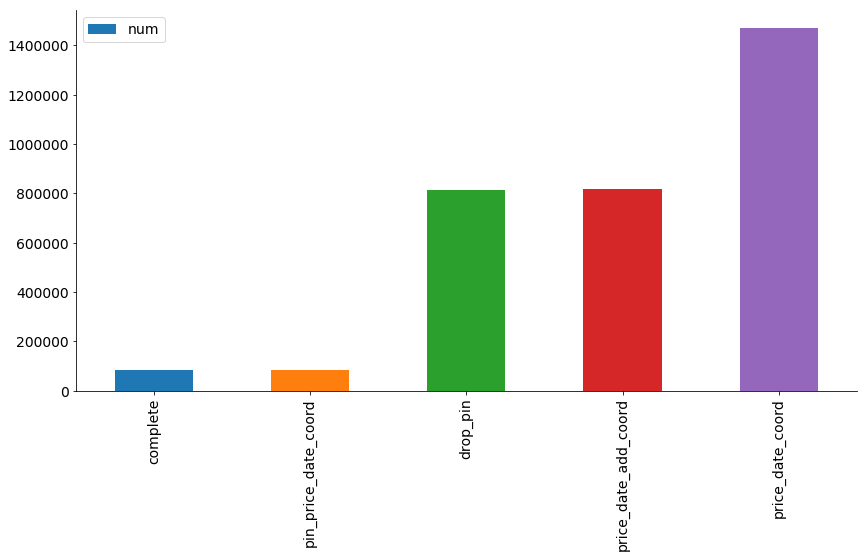

In [14]:
# create dictionary of dicts 'dup_col_dict' with different subsets to use for duplicate check

dup_col_dict = {
                'complete': {'sublist': list(data.columns)},            # records match in all columns
                        
                'pin_price_date_coord': {'sublist': ['pin', 'consideration_amt', 'registration_date', 'x', 'y']}, 
                                                                        # same pin, date, price, coordinates
                'drop_pin': {'sublist': list(data.columns.drop('pin'))},                   
                                                                        # match in all columns, but 'pin'
                'price_date_add_coord': {'sublist': ['consideration_amt', 'registration_date', 
                                                 'unitno', 'street_name', 'street_number',
                                                 'x', 'y']},         
                                                                        # same date, price, address, coordinates
                'price_date_coord': {'sublist': ['consideration_amt', 'registration_date', 'x', 'y']}         
                                                                        # same date, price, coordinates
                }

for key, value in dup_col_dict.items():
    
    print(f"\nDuplicate check using subset '{key}', with the following columns:\n", dup_col_dict[key]['sublist'])
    mask = data.duplicated(subset=value['sublist'])
    dup_col_dict[key]['num'] = len(data[mask])    
    print("\ndetects {0} duplicate entries.\n\n"
          .format(dup_col_dict[key]['num']))

dupl_df = pd.DataFrame(dup_col_dict)
dupl_df.T.plot.bar(y='num')
plt.show()

<a id='duplicate_check_results'></a>
#### Duplicate check results

* Duplicate check performed using all columns as criteria for detection gives the same result as the check that used only `'pin'`, `'consideration_amt'`, `'registration_date'`, and `coordinates`. Adding the other 11 columns does not reduce the number of duplicates detected.


* Check perfomed using all columns, but the `'pin'`, produces a ten-fold increase in the number of duplicates detected. These are transactions that are recorded for the same property, on the same date, and with a same price, but under different `'pin'`s. These entries represent a singe transaction being recorded under separate entries for unit, parking lot, _etc._, with the total price duplicated in each entry. **This criteria will be used to remove the duplicate entries from the dataset later in this section.**


* Check performed using just `'registration_date'`, `'consideration_amt'`, `address` information and `coordinates` detects a similar number of duplicates as the check that uses all columns with `'pin'` exluded.


* If `address` information is removed from the previous criteria, the check detects additional 653'549 duplicate entries. 

    * **This is an erratic result**, as entries with the same coordinates should probably have the same address information, and the check should produce results close to the previous one.
    
    * This could be an indication of inconsistency of entries in the columns containing `address` information, or their mismatch with `coordinates`.
<a id='remove_duplicates'></a>


#### Remove duplicate records from data frame `'data'` using criteria: all columns without `'pin'`

The data is filtered for duplicates with a duplicate check using the subset of all 14 columns with only `'pin'` excluded. This means that entries are considered duplicate if transactions match in everything, but might or might not have the same `'pin'` number.

* This eliminates 83'798 duplicates identical in everything, including `'pin'`, and 729'182 additional entries identical in everything, but the `'pin'`, that represent same transaction recorded in several entries using different `'pin'`s (represents separate entries for house, parking lot, _etc._)
    
* 813'138 duplicate entries are removed (9% of total), with 8'226'103 unique rows remaining

In [15]:
# set the subset to remove duplicates from data frame 'data'
dup_col_check = list(data.columns.drop('pin'))

# remove the duplicates from the data frame 'data'
data_len_dup = len(data)
data = data.drop_duplicates(subset=dup_col_check)
data_len_no_dup = len(data)
print("{0} duplicate entries removed from data frame 'data'!".
     format(
            data_len_dup - data_len_no_dup
            ))
print("New number of entries in the data frame 'data':", len(data))

813138 duplicate entries removed from data frame 'data'!
New number of entries in the data frame 'data': 8226103


#### Verification of results

In [16]:
for key, value in dup_col_dict.items():
    
    print(f"\nDuplicate check using subset '{key}', with the following columns:\n", dup_col_dict[key]['sublist'])
    mask = data.duplicated(subset=value['sublist'])
    dup_col_dict[key]['new_num'] = len(data[mask])    
    print("\ndetects {0} duplicate entries.\n\n"
          .format(dup_col_dict[key]['new_num']))


Duplicate check using subset 'complete', with the following columns:
 ['lro_num', 'pin', 'consideration_amt', 'registration_date', 'postal_code', 'province', 'unitno', 'street_name', 'street_designation', 'street_direction', 'municipality', 'street_suffix', 'street_number', 'x', 'y']

detects 0 duplicate entries.



Duplicate check using subset 'pin_price_date_coord', with the following columns:
 ['pin', 'consideration_amt', 'registration_date', 'x', 'y']

detects 0 duplicate entries.



Duplicate check using subset 'drop_pin', with the following columns:
 ['lro_num', 'consideration_amt', 'registration_date', 'postal_code', 'province', 'unitno', 'street_name', 'street_designation', 'street_direction', 'municipality', 'street_suffix', 'street_number', 'x', 'y']

detects 0 duplicate entries.



Duplicate check using subset 'price_date_add_coord', with the following columns:
 ['consideration_amt', 'registration_date', 'unitno', 'street_name', 'street_number', 'x', 'y']

detects 2813 dupl

As explained in [**Duplicate check results**](#duplicate_check_results) above, the check that uses `'consideration_amt'`, `'registration_amt'`, and `'coordinates'`, with `address` information excluded, produces additional 656'362 duplicate entries, potentially due to the discrepancy between `address` information and `coordinates`.

<a id='datetime_conversion'></a>
## 1.6 Datetime conversion

Back to the [top](#top) / [table of contents](#contents)

In this step:

* a record with an erratic time value [is fixed](#wrong_timestamp)
* registration date is [converted to datetime format](#convert_to_datetime)
* index of the data frame `'data'` is reset to `'registration_date'` and data is [resorted by date](#sort_by_date)
* new columns `'row_num'`, `'year'`, and `'decade'` are [added to the data frame](#sort_by_date)


<a id='wrong_timestamp'></a>
### 1.6.1 Record with a wrong time stamp

Back to [top](#top) / [table of contents](#contents)

Back to [step 1.6](#datetime_conversion)

One record appears to have a mistake in the date entry, the year digit is '0996', instead of '1996'.

In [17]:
data.loc[data['registration_date'] == '9/20/0996 0:00:00']

,lro_num,pin,consideration_amt,registration_date,postal_code,province,unitno,street_name,street_designation,street_direction,municipality,street_suffix,street_number,x,y
6706027,51,584050540,90000.0,9/20/0996 0:00:00,L4R5L4,ON,NaN,Golf Link,Rd,NaN,Midland,NaN,1504.0,-79.934438,44.746957


#### Correction:

In [18]:
data.at[6706027, 'registration_date'] =  '9/20/1996 0:00:00'
print("'registration_date' of record #6706027 was fixed!")

'registration_date' of record #6706027 was fixed!


<a id='convert_to_datetime'></a>
### 1.6.2 Converting `'registration_date'` to datetime format

Back to [top](#top) / [table of contents](#contents)

Back to [step 1.6](#datetime_conversion)

`'registration_date'`'s data type detects as an object (string) and it contains an empty time stamp 0:00:00 in each entry, type can be converted to Pandas datetime format (Pandas is a Python library for working with datasets).

#### Initial data type of `'registration_date'`

In [19]:
print("'registration_date' of entry 0:  ", data.loc[0, 'registration_date'])
print("It currently has the type of     ", type(data.loc[0, 'registration_date']))

'registration_date' of entry 0:   6/28/1909 0:00:00
It currently has the type of      <class 'str'>


#### Converting `'registration_date'` to datetime data type

In [20]:
# convert 'registration_date' from str to datetime data type
# errors can be set to 'coerce', but seems to parse fine
data.loc[:, 'registration_date'] = pd.to_datetime(data.loc[:, 'registration_date'], format='%m/%d/%Y %H:%M:%S')
print("'registration_date' converted to datetime data type!")

'registration_date' converted to datetime data type!


#### Verification of results

In [21]:
print("'registration_date' of entry 0:  ", data.loc[0, 'registration_date'])
print("It currently has the type of     ", type(data.loc[0, 'registration_date']))

'registration_date' of entry 0:   1909-06-28 00:00:00
It currently has the type of      <class 'pandas._libs.tslibs.timestamps.Timestamp'>


The empty time stamp 00:00:00 is still displayed when `'registraion_date'` values are requested directly, but will not be shown for other types of the display as `'registration_date'` is now processed as a Pandas Timestamp data type.

<a id='sort_by_date'></a>
### 1.6.3 Sorting data by date, adding new columns for `'row_num'`, `'year'`, and `'decade'`

Back to [top](#top) / [table of contents](#contents)

Back to [step 1.6](#datetime_conversion)

* First, index of the data frame `'data'` is set to `'registration_date'`.

* Then, the data frame is sorted using the new datetime index.

* Finally, new columns `'row_num'` containing row numbers, `'year'`, and `'decade'` are inserted at the beginning of the data frame.

In [22]:
# set index of data frame 'data' to 'registration_date'
print("Setting the index of data frame 'data' to 'registration_date'...Please wait...")
data.set_index('registration_date', inplace=True, drop=False)
print("Index set to registration date!\n\nSorting data frame 'data' by index...Please wait...")

# sort the data frame by datetime index
data = data.sort_index()
print("Data frame 'data' sorted by index!\n\nAdding a new column 'row_num' to data frame 'data'...Please wait...")

# add a new column 'row_num' to data frame 'data'
data.insert(0, 'row_num', np.arange(len(data)))
print("New column 'row_num' inserted into the data frame 'data'!\n\nAdding new columns 'year' and 'decade' to " +
     "data frame 'data'. Please wait...")

# add new columns 'year' and 'decade' to data frame 'data'
data.insert(1, 'year', data['registration_date'].astype('str'))
data.insert(1, 'decade', data['year'].str.slice(0, 3).astype('int32'))
data['year'] = data['year'].str.slice(0, 4).astype('int32')
print("Columns 'year' and 'decade' added to the data frame 'data'!\n\nEverything done!")

Setting the index of data frame 'data' to 'registration_date'...Please wait...
Index set to registration date!

Sorting data frame 'data' by index...Please wait...
Data frame 'data' sorted by index!

Adding a new column 'row_num' to data frame 'data'...Please wait...
New column 'row_num' inserted into the data frame 'data'!

Adding new columns 'year' and 'decade' to data frame 'data'. Please wait...
Columns 'year' and 'decade' added to the data frame 'data'!

Everything done!


<a id='missing_values'></a>
## 1.7 Missing values

Back to the [top](#top) / [table of contents](#contents)

#### Determining empty values and outliers for `'consideration_amt'`


* Empty (NaN) values for `'consideration_amt'` are set for all records with a price under 30 dollars. These records represent missing values and gift transactions and are not removed from the dataset, but will be excluded from statistical operations.


* No records from 1800-1820 have a price above 5 dollars, so `'consideration_amt'` on all of them is set to NaN.


* Outliers are not removed from the dataset, as they probably represent commercial/industrial transactions. Classification of transaction types can be performed before outliers are removed.


* Number of records with null and non-null values of `'consideration_amt'` is displayed by decade on a plot below.

#### Setting all values of `'consideration_amt'` under 30 dollars to NaN

Values of 'consideration_amt' of all records with price under 30 dollars are set to NaN!
1978245 values has been set to NaN! 'consideration_amt' now has 6247858 non-null entries.


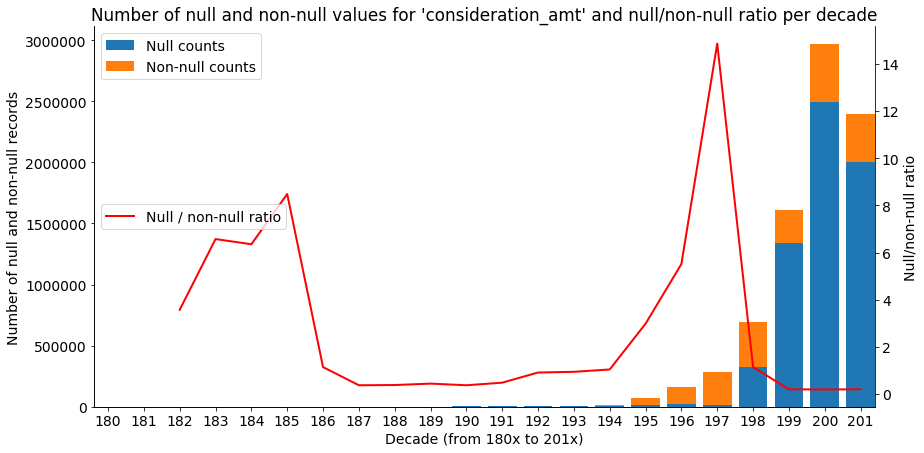

,180,181,182,183,184,185,186,187,188,189,...,192,193,194,195,196,197,198,199,200,201
non_null,0.000000,0.000000,7.00,7.00,17.00,141.00,288.00,1571.00,1560.00,1182.00,...,3133.00,2735.00,6709.00,18180.00,24490.00,18044.00,322302.00,1343986.0,2497665.00,2000055.0
null,5.000000,10.000000,25.00,46.00,108.00,1196.00,329.00,588.00,586.00,517.00,...,2856.00,2573.00,6979.00,54235.00,134937.00,268170.00,368414.00,269435.0,467830.00,396918.0
null_ratio,inf,inf,3.57,6.57,6.35,8.48,1.14,0.37,0.38,0.44,...,0.91,0.94,1.04,2.98,5.51,14.86,1.14,0.2,0.19,0.2


In [23]:
# set values of 'considertation_amt' of all records under 30 dollars to NaN (missing values) 
min_price = 30
mask = data['consideration_amt'] <= min_price
data['consideration_amt'] = np.where(mask, np.nan, data['consideration_amt'])
print(f"Values of 'consideration_amt' of all records with price under {min_price} dollars are set to NaN!")
print("{0} values has been set to NaN! 'consideration_amt' now has {1} non-null entries.".
       format(len(data) - data['consideration_amt'].count(),
              data['consideration_amt'].count()
              ))

# display number of non-null 'consideration_amt' and total number of entries per decade
price_nan = {} # empty dict to use in the loop
for decade, count in data.groupby('decade')['consideration_amt'].count().iteritems():
    price_nan[decade] = {
                         'non_null': int(count),
                         'null': int(data.groupby('decade')['consideration_amt'].size().loc[decade]) - count
                        }
price_nan_df = pd.DataFrame(price_nan) # generating a data frame 'price_nan_df' from dictionary 'price_nan'
price_nan_df_t = price_nan_df.T        # transposing the data frame 'price_nan_df' into 'price_nan_df_t'

price_nan_df_t['null_ratio'] = round(price_nan_df_t['null'] / price_nan_df_t['non_null'], 2)

# plotting results

# create a matplotlib figure and axes
_, ax1 = plt.subplots()
ax1.set_xlabel("Decade (from 180x to 201x)")
ax1.set_ylabel("Number of null and non-null records")
ax2 = ax1.twinx()
ax2.set_ylabel("Null/non-null ratio")
ax2.spines['right'].set_visible(True)
plt.title("Number of null and non-null values for 'consideration_amt' and null/non-null ratio per decade")

# select data to plot
null_counts = price_nan_df_t['null']
non_null_counts = price_nan_df_t['non_null']
nan_ratio = price_nan_df_t['null_ratio']
x = price_nan_df_t.index

# plot results
ax1.bar(x=x, height=non_null_counts, label='Null counts')
ax1.bar(x=x, height=null_counts, bottom=non_null_counts, label='Non-null counts')
ax2.plot(x, nan_ratio, lw=2, color='red', label='Null / non-null ratio')
ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.margins(x=0)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()
price_nan_df_t.T

<a id='price_nan'></a>
#### NaN values of `'consideration_amt'` by decade

* As can be seen from the plot above, there is an unreasonably high number of NaN values in the column `'consideration_amt'` (missing or under 30 dollars) for records from 1950s to 1970s (especially 1970s). 

    * The red curve on the plot above represents ratio of null to non-null records for `'consideration_amt'`, bars show number of null and non-null records, both are displayed per decade.
    * It can be seen that, apart from the older section of the dataset (prior to 1860s), the null/non-null ratio of the values of `'consideration_amt'` generally stayed under 1 (more non-null entries than null, or close to equal), or sometimes dropped much lower than that (significantly more non-null entries). 


* This is true for both the time period between 1860s-1940s and for the period between 1980s-2010s, despite a drastric difference in the number of records between the decades and in mean `'consideration_amt'`. The ratio of null/non-null transactions is comparable between the two time periods.


* However, for the time period between 1950s and 1970s, a drastic increase in relative number of null records can be seen in `'consideration_amt'`, with null/non-null ratio reaching 14.86 in 1970s.


* **This increase seems erratic, the number of transactions with `'consideration_amt'` missing or under 30 dollars from 1970s is unreasonably high, compared to the rest of the dataset.**

#### Summary information of the modified dataset

In [24]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8226103 entries, 1805-01-06 to 2017-10-11
Data columns (total 18 columns):
row_num               8226103 non-null int32
decade                8226103 non-null int32
year                  8226103 non-null int32
lro_num               8226103 non-null int64
pin                   8226103 non-null int64
consideration_amt     6247858 non-null float64
registration_date     8226103 non-null datetime64[ns]
postal_code           7101946 non-null object
province              7544525 non-null object
unitno                1489713 non-null float64
street_name           7847438 non-null object
street_designation    7108227 non-null object
street_direction      674995 non-null object
municipality          8196113 non-null object
street_suffix         166 non-null float64
street_number         7841470 non-null float64
x                     8216524 non-null float64
y                     8216524 non-null float64
dtypes: datetime64[ns](1), float64(6), i

`'consideration_amt'` is now showing 6'247'858 non-null values. `'row_num'`, `'year'`, and `'decade'` have been added. `'registration_date'` has been converted to datetime data format.

#### Number of missing values per column

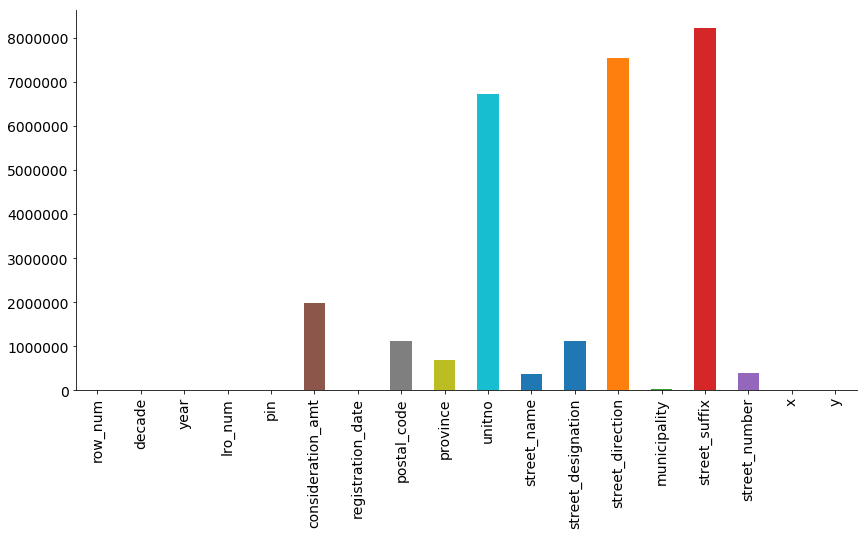

In [25]:
nan_count = data.shape[0] - data.count()
nan_count.plot(kind='bar')
plt.show()

* All values in added columns `'row_num'`, `'decade'`, and `'year'` are present.


* All values in columns `'lro_num'`, `'pin'`, `'registration_date'` and `'province'` are present. Almost all values in columns `'municipality'`, `'x'` and `'y'` are present.


* Most values in columns `'consideration_amt'`, `'postal_code'`, `'street_name'`, `'street_designation'`, and `'street_number'` are present.


* Most values in columns `'unitno'`, `'street_direction'`, and `'street_suffix'` are missing.


* There is a mismatch between the number of missing entries beteen `'street_name'` and `'street_designation'`, indicating some inconsistency of entries between the two columns (not all streets have designation).


* There is the same number of values in columns with coordinates `'x'` and `'y'`, indicating consistency of entries.


Consistency of entries for all columns is investigated further in the following step.

<a id='inconsistent_entries'></a>
## 1.8 Consistency of entries

Back to the [top](#top) / [table of contents](#contents)

Entries in the added columns `'row_num'`, `'year'`, and `'decade'` are consistent.

1. [`'lro_num'`](#lro_num) -- consistent. No changes were made.
2. [`'pin'`](#pin) -- duplicated, but consistent. No changes were made. Unique values largely match unique coordinate pairs.
3. [`'consideration_amt'`](#consideration_amt) -- consistent, changes were made in [step 1.7](#missing_values). Unexpectedly large number of values is either missing or under 30 dollars for time period between 1950s and 1970s (see [step 1.7](#price_nan)). Outliers are still present in the dataset, can be sorted out when classification of transaction types is performed (residential / commercial / industrial). Further investigation in **Part 2: Exploratory Data Analysis**.
4. [`'registration_date'`](#registration_date) -- consistent, verified during datetime conversion in [step 1.6](#datetime_conversion), where 1 erratic entry was fixed.
5. [`'postal_code'`](#postal_code) -- consistent, converted to upper case in [step 1.3](#capitalizations) as a preventive measure to ensure consistency.
6. [`'province'`](#province) -- consistent, missing values reset to 'ON'.
7. [`'unitno'`](#unitno) -- some erratic values are present, fixed in this section.
8. [`'street_name'`](#street_name) -- some inconsistent values are present, left for future targeted correction, capitalization fixed in [step 1.3](#capitalizations).
9. [`'street_designation'`](#street_designation) -- some inconsistent values are present, most common fixed in this step, capitalization fixed in [step 1.3](#capitalizations).
10. [`'street_direction'`](#street_direction) -- some inconsistent values are present, fixed in this step
11. [`'municipality'`](#municipality) -- some inconsistent values are present, fixed in this step, capitalization fixed in [step 1.3](#capitalizations).
12. [`'street_suffix'`](#street_suffix) -- numerical, but consistent, very few values are non-null.
13. [`'street_number'`](#street_number) -- consistent, some values are questionably large.
14. [`'x'` and `'y'`](#x_and_y) -- consistent. Unique pairs [largely match](#top_pins) unique `'pins'`, but there are [more coordinate pairs than `'pins'`](#pin_coord_diff). Therefore, some coordinate pairs must have different `'pin'`s of transactions recorded for the same location. No changes were made.

<a id='lro_num'></a>
### 1.8.1 Consistency of entries in the column `'lro_num'`

Back to [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Entries in the column `'lro_num'` appear to be consistent.
* Column `'lro_num'` could be converted to categorical data type, as it only contains a small range of values, but as it does not result in a significant reduction in memory use, its type is left as integer.
* No changes were made.
* There are no missing values.

Column `'lro_num'` captures the number of [Land Registry Office (LRO)](https://www.onland.ca/ui/) where each transaction was recorded.

There are some 54 Land Registry Offices located throughout Ontario. Each office is responsible for the recording of documents which relate to "Real Property" (real estate), such as the deed of land by which you own your house, mortgages of property, agreements dealing with land, municipal By-Laws affecting land, etc.

Distribution of `'consideration_amt'` between different LROs will be investigated further in **Part 2: Exploratory Data Analysis.**

#### Value counts for the column `'lro_num'`:

In [26]:
data['lro_num'].value_counts()

80    2326671
43    1169865
65    1008167
51     557831
40     549860
20     542401
62     472985
58     411916
59     238231
61     201024
30     198040
45     158838
2      120836
16      98593
7       71556
37      58363
18      40926
Name: lro_num, dtype: int64

<a id='pin'></a>
### 1.8.2 Consistency of entries in the column `'pin'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* In this step: 
    * records under each of the top 100'000 `'pin'`s (by number of entries with this `'pin'`) from the value count list are [checked for matching `coordinates`](#top_pins)  
    * number of records with the same `'pin'` [is compared with](#pin_coord_diff) how many of these records also have matching `'coordinates'`
    * value counts [are displayed](#pin_value_counts) for all values in the column `'pin'`.

* There are 4'653'452 entries with duplicate pins, but they appear to be consistent. 
    * Many records that have matching `'pin'`s also match on both `'x'` and `'y'` coordinates.
    * Thus, `'pin'` seems to be related to a particular building or complex in which transactions occur.
    * However, there are 941'006 more records with matching `coordinates` than those with matching `'pin'`.
    * These transactions occur in the same location (same coordinate pair), but under different `'pin'` numbers


* There are only 3'572'809 (43.4%) unique values of `'pin'` out of the total 8'226'261 entries.
* No changes were made.
* There are no missing values.

<a id='top_pins'></a>
#### 1.8.2.1 Top 100'000 `'pin'`s from the value count list have matching `'x'` and `'y'`coordinates for all records under every matching `'pin'`

Back to the [top](#top) / [contents](#contents)

Back to [step 1.8.2](#pin)

Back to [step 1.8](#inconsistent_entries)

As can be seen from the following check:

In [27]:
# save value counts for column 'pin' into a variable (pandas series)
pin_value_counts = data['pin'].value_counts()

# number of 'pin's to loop through 
n = 100000

# variable to count number of entries where 'x' and 'y' coordinates match for the same 'pin'
pin_coord_match = 0

# empty list to store 'pin's where not all 'x' and 'y' coordinates match
pin_coord_not_match = []

# loop through the top 'n' 'pin's in the value count list, check value counts for coordinates
for i in range(n):

    mask = data['pin'] == pin_value_counts.index[i] # select 'pin' number 'i' from the value count list
    num_rec = len(data[mask]) # number of records with selected 'pin'
    num_x = data.loc[mask, 'x'].value_counts(dropna=False).iloc[0] # max number of records with same 'x' from selected 'pin'
    num_y = data.loc[mask, 'y'].value_counts(dropna=False).iloc[0] # max number of records with same 'y' from selected 'pin'
    diff = (num_rec - num_x) + (num_rec - num_y) # number of records that don't match most common 'x' and 'y' from this 'pin'
    
    if diff > 0:
        print("There are records with same 'pin' {0} that have different coordinates.".format(pin_value_counts.index[i]))
        pin_coord_not_match.append(pin_value_counts.index[i])
    elif diff == 0:
        pin_coord_match += 1
    else:
        print("Something is wrong... Variable 'diff' < 0.")

print("Top {0} 'pin's from the value count list have been checked for matching coordinates.".format(n))
print("{0} 'pin's have been found to have all 'x' and 'y' coordinates match for the same 'pin'.".format(pin_coord_match))
print("List of 'pin's where not all coordinates match:\n", pin_coord_not_match)
print("\nThe last 'pin' checked has {0} matching records (records with this 'pin').".format(len(data[mask])))

Top 100000 'pin's from the value count list have been checked for matching coordinates.
100000 'pin's have been found to have all 'x' and 'y' coordinates match for the same 'pin'.
List of 'pin's where not all coordinates match:
 []

The last 'pin' checked has 6 matching records (records with this 'pin').


The top 100'000 `'pin'`s (by number of entries with this `'pin'`) from the value count list have matching `'x'` and `'y'` coordinates for every matching `'pin'`. This includes `'pin'`s with at least 6 records under them. Deeper checks are time-intensive and can be performed if needed.

<a id='pin_coord_diff'></a>
#### 1.8.2.2 However, there are more records with matching `coordinates` than there are with matching `'pin'`s

Back to the [top](#top) / [contents](#contents)

Back to [step 1.8.2](#pin)

Back to [step 1.8](#inconsistent_entries)

In [28]:
print("There are {0} more records with matching 'x' and 'y' coordinates than records with matching 'pin'.".
     format(
            len(data[data.duplicated(subset=['x', 'y'])]) - len(data[data.duplicated(subset='pin')])
            ))

There are 941006 more records with matching 'x' and 'y' coordinates than records with matching 'pin'.


941'006 records are recorded with the same `coordinates`, but under different `'pin'`s.

<a id='pin_value_counts'></a>
#### 1.8.2.3 Value counts for the column `'pin'`:

Back to the [top](#top) / [contents](#contents)

Back to [step 1.8.2](#pin)

Back to [step 1.8](#inconsistent_entries)

In [29]:
data['pin'].value_counts()

102510001    647
211080033    587
584120166    542
584120142    540
584120124    538
584200216    536
584200218    536
584200217    535
584120097    504
584120092    504
584120046    502
584190072    438
584190237    438
584190120    436
584280284    431
584280220    428
584280249    425
584280172    425
584280227    424
584280423    423
584280463    420
102510739    418
34970524     410
34970441     355
34970406     350
284350220    346
284350218    346
284350219    346
284350189    346
34971051     345
            ... 
222560448      1
80130198       1
37720014       1
583430286      1
264200148      1
100620245      1
134150113      1
193930449      1
263490068      1
763500547      1
641880074      1
297951244      1
226650125      1
33720337       1
381870108      1
264450086      1
281260086      1
142850103      1
29610042       1
134240331      1
297820236      1
763390029      1
297840726      1
121700448      1
247550058      1
642260022      1
373040298      1
463870543     

<a id='consideration_amt'></a>
### 1.8.3 Consistency of entries in the column `'consideration_amt'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Values in `'consideration_amt'` detect as float data type, indicating consistantly numerical values. 
* Values of 1'978'245 entries with `'consideration_amt'` of less than or equal to 30 dollars have been reset to NaN (missing values) in [step 1.7](#missing_values). 
* There is an unreasonably high number of NaN values in the column `'consideration_amt'` (missing or under 30 dollars) for records from 1950s to 1970s (especially 1970s). See [step 1.7](#price_nan)
* After [step 1.7](#missing_values), there are 6'247'986 (80%) non-null entries of the total 8'226'261 in the column `'consideration_amt'`.
* Outliers are still present in the dataset and will be sorted out in future Parts along with the classification of transactions (residential/commercial/industrial).
* More detailed examination of distribution of values of `'consideration_amt'` will follow in **Part 2: Exploratory Data Analysis.**
* No chages were made in this section.

#### Statistical summary for the column `'consideration_amt'`:

In [30]:
data['consideration_amt'].describe()

count    6.247858e+06
mean     5.633393e+05
std      1.900839e+08
min      3.100000e+01
25%      1.530000e+05
50%      2.399790e+05
75%      3.720000e+05
max      4.477478e+11
Name: consideration_amt, dtype: float64

<a id='registration_date'></a>
### 1.8.4 Consistency of entries in the column `'registration_date'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Consistency of entries in the column `'registration_date'` was verified during datetime conversion in [step 1.6](#datetime_conversion), where 1 entry was fixed.
* Entries are consistent.
* Data is sorted by values in this column. Numbers of rows in `'row_num'` go in the order from earliest date in the dataset to the latest.
* No changes were made in this section.
* There are no missing values.

<a id='postal_code'></a>
### 1.8.5 Consistency of entries in the column `'postal_code'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Values were converted to upper case in [step 1.3](#capitalizations) (this is a preventive measure, no issues were detected with values in this column).
* Entries in the column `'postal_code'` appear to be consistent.
* No changes were made.
* There are 7'101'946 (86.3%) non-null values of 8'226'261 total. 1'124'157 entries are missing.

#### Verifying that values in the column `'postal_code'` match the correct pattern.

In [31]:
data['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$').value_counts(dropna=False)

True    7101946
NaN     1124157
Name: postal_code, dtype: int64

All values in the column `'postal_code'` either match the correct pattern or are missing.

#### Value counts for the column `'postal_code'`:

In [32]:
data['postal_code'].value_counts()

L0S1J0    7848
L0R1W0    6255
L0S1N0    5108
L0R1C0    4850
N0B1E0    4644
L4P3E9    4601
L2P3H1    4502
K0L2H0    4400
L9Y5B4    4330
L0G1W0    4307
M1H3G6    4120
L0R2A0    3944
M8V3W9    3642
M8V2Z6    3640
L0K1E0    3597
N0B1S0    3573
L0G1M0    3563
L0E1N0    3495
L0L1P0    3302
M1H3H3    3295
L0M1S0    3115
M2M4J4    3043
L0G1A0    3041
L0K2A0    3035
L0E1R0    3005
L9M1R3    2869
M5B2P7    2851
N0B2T0    2842
L0R2H5    2842
L0P1B0    2834
          ... 
M1L4S2       1
L3C1W1       1
L2V1A4       1
M2H1S5       1
M5M3A3       1
L9T3J6       1
L2J3R9       1
L2N7Z2       1
N2J4L2       1
L3R4Y4       1
N3C4P7       1
L2A3X6       1
M1S1S7       1
M4Y1C2       1
L1C1R5       1
L3R0E1       1
M6P1W7       1
K9J1Y5       1
L4S1K6       1
L4R2P1       1
L9Y3K3       1
N1W2W4       1
M4V1B3       1
M1P2H1       1
L9C5C8       1
L3Y5B2       1
L4G2H7       1
L4Y3P6       1
L2J2W4       1
M5H4E5       1
Name: postal_code, Length: 170356, dtype: int64

Entries in the column `'postal_code'` appear to be consistent.

<a id='province'></a>
### 1.8.6 Consistency of entries in the column `'province'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Missing values are reset to 'ON'.
* Entries are consistent, there are no missing values, as all the transactions occur in Ontario.
* This column does not carry any useful information in the context of Teranet dataset, as all the transactions occur in Ontario, and could be removed. However, since it does not result in significant reduction in memory use, column `'province'` is left in the dataset, in case if the dataset will be merged with data from other provinces in the future.

In [33]:
data['province'].value_counts()

ON    7544525
Name: province, dtype: int64

In [34]:
data['province'] = 'ON'

In [35]:
data['province'].value_counts()

ON    8226103
Name: province, dtype: int64

All values in `'province'` have been reset to 'ON'.

<a id='unitno'></a>
### 1.8.7 Consistency of entries in the column `'unitno'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Values in `'unitno'` detect as float data type, indicating numerical entries.
* Many records have erratic entries (e.g., 200000000, 1.010000e-107, etc.), all of them have been fixed in this section.
* There are 1'489'665 non-null (18%) of the total 8'226'103 entries.

### Fixing inconsistent entries in `'unitno'`

#### Erratic value 1.010000e-107

In [36]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1.01')
                      )
data.loc[mask, 'unitno'].value_counts()

1.010000e-107    1
Name: unitno, dtype: int64

#### Correction

In [37]:
data.loc[mask, 'unitno'] = 101
data.loc[mask, 'unitno'].value_counts()

101.0    1
Name: unitno, dtype: int64

#### Erratic values 1.100000e-x

In [38]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1.1')
                      )
data.loc[mask, 'unitno'].value_counts()

1.100000e-201    4
1.100000e-12     1
1.100000e-11     1
Name: unitno, dtype: int64

#### Correction

In [39]:
data.loc[mask, 'unitno'] = 11
data.loc[mask, 'unitno'].value_counts()

11.0    6
Name: unitno, dtype: int64

#### Erratic values 1.200000e-x

In [40]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1.2')
                      )
data.loc[mask, 'unitno'].value_counts()

1.200000e-103    4
1.200000e-200    3
Name: unitno, dtype: int64

#### Correction

In [41]:
data.loc[mask, 'unitno'] = 12
data.loc[mask, 'unitno'].value_counts()

12.0    7
Name: unitno, dtype: int64

#### Erratic values 1.700000e-06

In [42]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1.7')
                      )
data.loc[mask, 'unitno'].value_counts()

0.000002    2
Name: unitno, dtype: int64

#### Correction

In [43]:
data.loc[mask, 'unitno'] = 17
data.loc[mask, 'unitno'].value_counts()

17.0    2
Name: unitno, dtype: int64

#### Erratic value 1.800000e-19

In [44]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1.8')
                      )
data.loc[mask, 'unitno'].value_counts()

1.800000e-19    1
Name: unitno, dtype: int64

#### Correction

In [45]:
data.loc[mask, 'unitno'] = 18
data.loc[mask, 'unitno'].value_counts()

18.0    1
Name: unitno, dtype: int64

#### Erratic values 1.000000e-x

In [46]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('1')
                      )
data.loc[mask, 'unitno'].value_counts()

1.000000e+17     4
1.000000e-10     4
1.000000e+21     3
1.000000e-20     3
1.000000e+19     3
1.000000e+26     3
1.000000e-101    3
1.000000e-103    2
1.000000e+25     2
1.000000e+13     2
1.000000e-202    2
1.000000e-205    2
1.000000e+20     2
1.000000e-102    2
1.000000e+27     2
1.000000e+12     2
1.000000e-302    2
1.000000e+22     2
1.000000e+18     2
1.000000e+23     2
1.000000e-303    1
1.000000e+15     1
1.000000e-301    1
1.000000e-05     1
1.000000e+16     1
Name: unitno, dtype: int64

#### Correction

In [47]:
data.loc[mask, 'unitno'] = 1
data.loc[mask, 'unitno'].value_counts()

1.0    54
Name: unitno, dtype: int64

#### Erratic value 2.000000e-x

In [48]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('2')
                      )
data.loc[mask, 'unitno'].value_counts()

2.000000e-101    6
2.000000e-106    5
2.000000e-205    4
2.000000e-104    4
2.000000e-12     3
2.000000e-123    3
2.000000e+13     3
2.000000e-202    3
2.000000e-22     3
2.000000e-06     2
2.000000e+21     2
2.000000e+18     2
2.000000e+105    2
2.000000e+19     2
2.000000e-20     2
2.000000e+155    2
2.000000e+12     2
2.000000e+15     2
2.000000e-05     1
2.000000e-303    1
Name: unitno, dtype: int64

#### Correction

In [49]:
data.loc[mask, 'unitno'] = 2
data.loc[mask, 'unitno'].value_counts()

2.0    54
Name: unitno, dtype: int64

#### Erratic values 3.300000e-33

In [50]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('3')
                      )
data.loc[mask, 'unitno'].value_counts()

3.300000e-33    3
Name: unitno, dtype: int64

#### Correction

In [51]:
data.loc[mask, 'unitno'] = 33
data.loc[mask, 'unitno'].value_counts()

33.0    3
Name: unitno, dtype: int64

#### Erratic values 4.000000e-104

In [52]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('4')
                      )
data.loc[mask, 'unitno'].value_counts()

4.000000e-104    4
Name: unitno, dtype: int64

#### Correction

In [53]:
data.loc[mask, 'unitno'] = 4
data.loc[mask, 'unitno'].value_counts()

4.0    4
Name: unitno, dtype: int64

#### Erratic values 5.000000e-x

In [54]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('5')
                      )
data.loc[mask, 'unitno'].value_counts()

5.000000e-102    3
5.000000e-103    3
5.000000e-06     1
Name: unitno, dtype: int64

#### Correction

In [55]:
data.loc[mask, 'unitno'] = 5
data.loc[mask, 'unitno'].value_counts()

5.0    7
Name: unitno, dtype: int64

#### Erratic values 6.000000e-x

In [56]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('6')
                      )
data.loc[mask, 'unitno'].value_counts()

6.000000e-104    4
6.000000e-201    3
6.000000e-22     2
Name: unitno, dtype: int64

#### Correction

In [57]:
data.loc[mask, 'unitno'] = 6
data.loc[mask, 'unitno'].value_counts()

6.0    9
Name: unitno, dtype: int64

#### Erratic value 8.000000e-206

In [58]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('8')
                      )
data.loc[mask, 'unitno'].value_counts()

8.000000e-206    1
Name: unitno, dtype: int64

#### Correction

In [59]:
data.loc[mask, 'unitno'] = 8
data.loc[mask, 'unitno'].value_counts()

8.0    1
Name: unitno, dtype: int64

#### Erratic values 9.000000e-104

In [60]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('e'),
                      data_subset.str.match('9')
                      )
data.loc[mask, 'unitno'].value_counts()

9.000000e-104    7
Name: unitno, dtype: int64

#### Correction

In [61]:
data.loc[mask, 'unitno'] = 9
data.loc[mask, 'unitno'].value_counts()

9.0    7
Name: unitno, dtype: int64

#### Erratic values 100000x and 20000x

#### Data frame `'data'` resorted by `'unitno'`

In [62]:
data.sort_values(by='unitno', na_position='last', inplace=True, ascending=False)
data.iloc[:25, 9]

registration_date
2007-07-13    2.000000e+11
2013-09-03    2.000000e+11
2007-07-13    2.000000e+11
2007-07-17    1.000000e+11
2007-07-17    1.000000e+11
2007-07-13    2.000000e+10
2007-07-17    1.000000e+10
2007-07-13    1.000000e+10
2010-06-29    1.000000e+10
2007-07-13    1.000000e+09
2010-06-29    1.000000e+09
2007-08-13    2.000000e+08
2007-07-13    2.000000e+08
2007-07-24    2.000000e+08
2010-06-29    1.000000e+08
2007-07-13    1.000000e+08
2007-07-13    2.000000e+07
2007-08-13    2.000000e+07
2007-07-24    2.000000e+07
2007-07-13    1.000000e+07
2010-06-29    1.000000e+07
2013-04-15    2.000000e+06
2007-07-12    2.000000e+06
2007-07-13    1.000000e+06
2010-06-29    1.000000e+06
Name: unitno, dtype: float64

#### Correction

In [63]:
data_subset = data.iloc[:25, 9].astype(str)
data.iloc[:25, 9] = data_subset.str.strip('00000000000.0').astype('int64')
data.iloc[:25, 9]

registration_date
2007-07-13    2.0
2013-09-03    2.0
2007-07-13    2.0
2007-07-17    1.0
2007-07-17    1.0
2007-07-13    2.0
2007-07-17    1.0
2007-07-13    1.0
2010-06-29    1.0
2007-07-13    1.0
2010-06-29    1.0
2007-08-13    2.0
2007-07-13    2.0
2007-07-24    2.0
2010-06-29    1.0
2007-07-13    1.0
2007-07-13    2.0
2007-08-13    2.0
2007-07-24    2.0
2007-07-13    1.0
2010-06-29    1.0
2013-04-15    2.0
2007-07-12    2.0
2007-07-13    1.0
2010-06-29    1.0
Name: unitno, dtype: float64

#### Erratic values 0.2400 and 0.0024

In [64]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('24'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.2400    4
0.0024    2
Name: unitno, dtype: int64

#### Correction

In [65]:
data.loc[mask, 'unitno'] = 24
data.loc[mask, 'unitno'].value_counts()

24.0    6
Name: unitno, dtype: int64

#### Erratic values 0.000815

In [66]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('815'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.000815    2
Name: unitno, dtype: int64

#### Correction

In [67]:
data.loc[mask, 'unitno'] = 815
data.loc[mask, 'unitno'].value_counts()

815.0    2
Name: unitno, dtype: int64

#### Erratic values 0.0026

In [68]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('26'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.0026    3
Name: unitno, dtype: int64

#### Correction

In [69]:
data.loc[mask, 'unitno'] = 26
data.loc[mask, 'unitno'].value_counts()

26.0    3
Name: unitno, dtype: int64

#### Erratic values 0.010 and 0.001

In [70]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('1'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.010    5
0.001    5
Name: unitno, dtype: int64

#### Correction

In [71]:
data.loc[mask, 'unitno'] = 1
data.loc[mask, 'unitno'].value_counts()

1.0    10
Name: unitno, dtype: int64

#### Erratic values 0.2000, 0.0200, 0.0002, and 0.0020

In [72]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('2'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.2000    22
0.0200     2
0.0002     1
0.0020     1
Name: unitno, dtype: int64

#### Correction

In [73]:
data.loc[mask, 'unitno'] = 2
data.loc[mask, 'unitno'].value_counts()

2.0    26
Name: unitno, dtype: int64

#### Erratic values 0.37

In [74]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('37'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.37    5
Name: unitno, dtype: int64

#### Correction

In [75]:
data.loc[mask, 'unitno'] = 37
data.loc[mask, 'unitno'].value_counts()

37.0    5
Name: unitno, dtype: int64

#### Erratic values 0.033

In [76]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('33'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.033    1
Name: unitno, dtype: int64

#### Correction

In [77]:
data.loc[mask, 'unitno'] = 33
data.loc[mask, 'unitno'].value_counts()

33.0    1
Name: unitno, dtype: int64

#### Erratic values 0.003

In [78]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('03'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.003    9
Name: unitno, dtype: int64

#### Correction

In [79]:
data.loc[mask, 'unitno'] = 3
data.loc[mask, 'unitno'].value_counts()

3.0    9
Name: unitno, dtype: int64

#### Erratic values 0.83

In [80]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('83'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.83    3
Name: unitno, dtype: int64

#### Correction

In [81]:
data.loc[mask, 'unitno'] = 83
data.loc[mask, 'unitno'].value_counts()

83.0    3
Name: unitno, dtype: int64

#### Erratic values 0.04

In [82]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('4'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.04    2
Name: unitno, dtype: int64

#### Correction

In [83]:
data.loc[mask, 'unitno'] = 4
data.loc[mask, 'unitno'].value_counts()

4.0    2
Name: unitno, dtype: int64

#### Erratic values 0.66

In [84]:
data_subset = data['unitno'].astype(str)

mask = np.logical_and(
                      data_subset.str.contains('6'),
                      data_subset.str.match('0.')
                      )
data.loc[mask, 'unitno'].value_counts()

0.66    5
Name: unitno, dtype: int64

#### Correction

In [85]:
data.loc[mask, 'unitno'] = 66
data.loc[mask, 'unitno'].value_counts()

66.0    5
Name: unitno, dtype: int64

#### Missing values 0.000000

`'unitno'` values 0.0 are reset to NaN (missing values).

In [86]:
data_subset = data['unitno'].astype(str)

mask = data_subset.str.match('0')
data.loc[mask, 'unitno'].value_counts()

0.0    48
Name: unitno, dtype: int64

#### Correction

In [87]:
data.loc[mask, 'unitno'] = np.nan
data.loc[mask, 'unitno'].value_counts()

Series([], Name: unitno, dtype: int64)

Reqeust returns empty series -- all 0.0 values have been reset to NaN.

#### Top 10 values of `'unitno'`

In [88]:
data.sort_values(by='unitno', na_position='last', inplace=True, ascending=True)
data.iloc[:10, 9]

registration_date
1996-06-03    1.0
2006-03-24    1.0
1979-12-31    1.0
1994-07-04    1.0
1994-06-30    1.0
2013-05-15    1.0
2006-07-04    1.0
2006-03-23    1.0
1994-07-04    1.0
1980-01-04    1.0
Name: unitno, dtype: float64

#### Bottom 10 values of `'unitno'`

In [89]:
data.sort_values(by='unitno', na_position='last', inplace=True, ascending=False)
data.iloc[:10, 9]

registration_date
2007-05-23    25607.0
2011-08-08    22605.0
2012-03-15    22605.0
2003-06-26    22207.0
1979-06-27    19121.0
2016-11-25    19121.0
1999-06-15    19121.0
2004-02-27    19121.0
2012-10-10    17055.0
2007-07-09    15201.0
Name: unitno, dtype: float64

#### Resorting data frame `'data'` by `'registration_date'`

In [90]:
data = data.sort_index()
print("Data frame 'data' sorted by index!")

Data frame 'data' sorted by index!


All entries in column `'unitno'` have been fixed. There are 1'489'665 non-null (18%) of the total 8'226'103 entries.

<a id='street_name'></a>
### 1.8.8 Inconsistent entries in `'street_name'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Inconsistencies have been found in the column `'street_name'`, but their correction in the whole dataset presents a time-intensive task. Targeted correction can be performed for particular streets later, if needed. 
* **Entries in `'street_name'` have not been corrected.**
* There are 7'847'438 non-null (95%) of the total 8'226'103 entries.

#### Example: Bathurst

* misspelling
* additional info included (e.g., -Storage Unit, unit/suite no, zip code)
* extra space
* St vs Street

In [91]:
mask = data['street_name'].str.contains(pat='Bathurst', case=False, na=False)
data.loc[mask, 'street_name'].value_counts()

Bathurst                        11951
Bathurst Street                  1026
Bathurst Glen                     203
Bathurst St                        38
Old Bathurst                       25
Bathurst Street Rear                4
Bathurst Street North               4
Bathurst  Street                    4
Bathurst Street West                4
Bathurst Stree                      3
Old Bathurst Street                 3
Bathurst Street (Potl#121)          3
111 Bathurst Inc                    2
Bathurst Avenue                     1
Bathurst Strert                     1
Bathurst Street, Suite 1611         1
Bathurst Street, Unit 1615          1
Bathurst Street  L4J 0B8            1
Bathurst Street-Storage Unit        1
Bathurst St Rear                    1
7890 Bathurst                       1
Bathurst Street   L4J 0B8           1
Old Bathurst St                     1
Bathurst Inc                        1
Name: street_name, dtype: int64

#### Example: Yonge

* misspelling
* additional info included (e.g., -Storage Unit, unit/suite no, zip code)
* extra spaces
* St vs Street

In [92]:
mask = data['street_name'].str.contains(pat='Yonge', case=False, na=False)
data.loc[mask, 'street_name'].value_counts()

Yonge                                 57394
Yonge Street                           1466
Old Yonge                               310
Yongehurst                              193
Yonge St                                160
Yongeview                                49
Yonge St S                               19
Old Yonge Street                         16
Yonge Street South                       16
Yonge St N                               12
Yongeview Avenue                          9
- 1210 Yonge Street                       7
Yonge Street North                        7
Yongehurst Avenue                         6
Yonge Stree                               6
Roselawn Ave. & 2400 Yonge Street         5
Yonge Street Highway 11                   5
Yonge Street South Of Ravenshoe           5
8674 Yonge Street                         4
Yonge Steet                               4
Old Yonge St                              3
Yonge Stret                               3
Yonge St L3T 2B4                

#### Example: Highway

* `#` or 'No' included
* 'RR' vs 'R.R.'
* additional info included,
* Highway vs Hwy (see next)

In [93]:
mask = data['street_name'].str.contains(pat='highw', case=False, na=False)
data.loc[mask, 'street_name'].value_counts()

Highway 8                          1208
Highway 48                          970
Highway 7                           834
Highway West                        509
Highway 2                           489
Highway 3                           472
Highway 26                          461
Highway 6                           460
Highway 24                          447
Highway 12                          416
Highway 27                          409
Highway 9                           395
Highway 89                          376
Highway No. 7                       330
Highway 7 West                      293
Highway 20                          219
Highway 10                          183
Highway 7A                          176
Highway 59                          174
Highway 50                          149
Highwood                            144
Highway 93                          135
Highway 54                          124
Highway 11                          119
Highway #53                         108


In [94]:
mask = data['street_name'].str.contains(pat='hwy', case=False, na=False)
data.loc[mask, 'street_name'].value_counts()

Hwy 6                          845
Hwy 7                          788
Hwy 3                          592
Hwy 20                         489
Hwy 12                         470
Hwy 2                          456
Hwy 28                         372
Hwy 9                          345
Hwy 56                         337
Hwy 47                         314
Hwy 26                         285
Hwy 89                         261
Hwy 11                         236
Hwy 20 West                    223
Hwy 8                          164
Provincial Hwy 11              153
Hwy 27                         151
Hwy 99                         150
Hwy #3                         131
Hwy 20 W                       117
Hwy 7A                         116
Hwy 25                         107
Hwy 48                         104
Provincial Hwy 12              104
Hwy 54                          97
Hwy #6 South                    96
Hwy 507                         91
Hwy                             91
Old Hwy 8           

Fixing values in the column `'street_name'` in the full dataset presents a time-intensive task. It makes more sense to perform targeted cleanups for particular street names, if the need arises. This could be done at a later stage.

<a id='street_designation'></a>
### 1.8.9 Inconsistent values in the column `'street_designation'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Inconsistent entries have been found in the column `'street_designation'`, such as 'St', 'St.' and 'Street'.
* Some inconsistencies have been fixed, however this presents a time intensive task and some more might still be present in the dataset.
* There are 7'108'227 non-null (86%) of the total 8'226'103 entries.
* There are less values of `'street_designation'` present in the dataset than those of `'street_name'` (7'108'227 - 7'847'438 = 739'211 values of `'street_designation'` are missing).

### Fixing inconsistent entries in `'street_designation'`

#### St, St., and Street

In [95]:
mask = data['street_designation'].str.match(pat='St', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

St        1302109
Street        126
St w            8
St.             1
Name: street_designation, dtype: int64

#### Correction

In [96]:
data.loc[mask, 'street_designation'] = 'St'
data.loc[mask, 'street_designation'].value_counts()

St    1302244
Name: street_designation, dtype: int64

#### Dr and Drive

In [97]:
mask = data['street_designation'].str.match(pat='dr', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Dr       1258763
Drive        121
Name: street_designation, dtype: int64

#### Correction

In [98]:
data.loc[mask, 'street_designation'] = 'Dr'
data.loc[mask, 'street_designation'].value_counts()

Dr    1258884
Name: street_designation, dtype: int64

#### Av, Ave, and Avenue

In [99]:
mask = data['street_designation'].str.match(pat='av', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Ave       1176671
Avenue        364
Av              4
Ave 5           2
Name: street_designation, dtype: int64

#### Correction

In [100]:
data.loc[mask, 'street_designation'] = 'Ave'
data.loc[mask, 'street_designation'].value_counts()

Ave    1177041
Name: street_designation, dtype: int64

#### Rd

In [101]:
mask = data['street_designation'].str.match(pat='rd', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Rd        1018322
Rd 19         115
Rd 124          9
Rd 30           5
Rd w            2
Rd.             2
Name: street_designation, dtype: int64

#### Correction

In [102]:
data.loc[mask, 'street_designation'] = 'Rd'
data.loc[mask, 'street_designation'].value_counts()

Rd    1018455
Name: street_designation, dtype: int64

#### Cres, Cresent, and Crescent

In [103]:
mask = data['street_designation'].str.match(pat='cre', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Cres        802764
Crescent       125
Cresent         74
Name: street_designation, dtype: int64

#### Correction

In [104]:
data.loc[mask, 'street_designation'] = 'Cres'
data.loc[mask, 'street_designation'].value_counts()

Cres    802963
Name: street_designation, dtype: int64

#### Blvd and Boulevard

In [105]:
mask = np.logical_or(
                     data['street_designation'].str.match(pat='blv', case=False, na=False),
                     data['street_designation'].str.match(pat='bou', case=False, na=False)
                    )
data.loc[mask, 'street_designation'].value_counts()

Blvd         305148
Boulevard        50
Name: street_designation, dtype: int64

#### Correction

In [106]:
data.loc[mask, 'street_designation'] = 'Blvd'
data.loc[mask, 'street_designation'].value_counts()

Blvd    305198
Name: street_designation, dtype: int64

#### Pky, Pkwy and Parkway

In [107]:
filter_list = ['Pky', 'Pkwy', 'Parkway']
mask = data['street_designation'].isin(filter_list)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'street_designation'].value_counts()

Total 22548 entries.


Pky        22525
Pkwy          12
Parkway       11
Name: street_designation, dtype: int64

#### Correction

In [108]:
data.loc[mask, 'street_designation'] = 'Parkway'
data.loc[mask, 'street_designation'].value_counts()

Parkway    22548
Name: street_designation, dtype: int64

#### Pk, Park and Parc

In [109]:
filter_list = ['Pk', 'Park', 'Parc']
mask = data['street_designation'].isin(filter_list)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'street_designation'].value_counts()

Total 1846 entries.


Pk      1834
Park       8
Parc       4
Name: street_designation, dtype: int64

#### Correction

In [110]:
data.loc[mask, 'street_designation'] = 'Park'
data.loc[mask, 'street_designation'].value_counts()

Park    1846
Name: street_designation, dtype: int64

#### Trail and Trl

In [111]:
mask = data['street_designation'].str.match(pat='tr', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Trail    80606
Trl          4
Name: street_designation, dtype: int64

#### Correction

In [112]:
data.loc[mask, 'street_designation'] = 'Trail'
data.loc[mask, 'street_designation'].value_counts()

Trail    80610
Name: street_designation, dtype: int64

#### Sq and Square

In [113]:
mask = data['street_designation'].str.match(pat='sq', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Sq        44122
Square        2
Name: street_designation, dtype: int64

#### Correction

In [114]:
data.loc[mask, 'street_designation'] = 'Square'
data.loc[mask, 'street_designation'].value_counts()

Square    44124
Name: street_designation, dtype: int64

#### Terr and Terrace

In [115]:
mask = data['street_designation'].str.match(pat='te', case=False, na=False)
data.loc[mask, 'street_designation'].value_counts()

Terr       32170
Terrace       36
Name: street_designation, dtype: int64

#### Correction

In [116]:
data.loc[mask, 'street_designation'] = 'Terrace'
data.loc[mask, 'street_designation'].value_counts()

Terrace    32206
Name: street_designation, dtype: int64

#### Value counts for `'street_designation'`

In [117]:
data['street_designation'].value_counts()

St          1302244
Dr          1258884
Ave         1177041
Rd          1018455
Cres         802963
Crt          345141
Blvd         305198
Way          136951
Pl           131466
Lane         123051
Cir          117545
Trail         80610
Line          45106
Square        44124
Terrace       32206
Gate          24876
Parkway       22548
Quay          18529
Mews          11913
Gdns          11769
Hwy            9427
Grove          8911
Hts            7368
Espl           6560
Sideroad       5990
Conc           4858
Path           4108
Ptway          3405
Ridge          3139
Side rd        3100
             ...   
Circle           22
Plaza            20
Dell             19
Farm             19
Pines            19
Thick            18
Estate           15
Ct               13
First            13
Ctr              12
Wynd             11
18               11
Lac              11
Abbey            11
Orch              8
Key               7
Townline          6
Ch                5
Exten             5


Most common inconsistencies have been fixed in `'street_designation'`, but **some more might be present in the dataset,** since this presents a time-intensive task. More fixes can be made at a later stage, if the need arises.

<a id='street_direction'></a>
### 1.8.10 Consistency of entries in the column `'street_direction'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Some inconsistencies have been found in the column `'street_direction'`, such as values 'N' and 'NORTH'.
* All inconsistencies have been fixed in this step.
* There are 674'995 non-null (8%) of the total 8'226'103 entries.

#### Initial values

Value counts are displayed for column `'street_direction'` to check for consistency of entries.

In [118]:
data.street_direction.value_counts()

W        276487
E        218865
N        100935
S         78467
WEST        116
SW           44
SE           43
NE           19
SOUTH         8
NORTH         6
R             2
ES            2
?             1
Name: street_direction, dtype: int64

* 'WEST' needs to be converted to 'W'

* 'SOUTH' needs to be converted to 'S'

* 'NORTH' needs to be converted to 'N'

* 'ES' needs to be converted to 'SE'

* 'R' needs to be converted to NaN

* '?' needs to be converted to NaN

#### Correcting inconsistent entries in `'street_direction'`

In [119]:
# correcting entries for consistency in 'street_direction'
mask = data['street_direction'] == 'WEST'
data['street_direction'] = np.where(mask, 'W', data['street_direction'])

mask = data['street_direction'] == 'SOUTH'
data['street_direction'] = np.where(mask, 'S', data['street_direction'])

mask = data['street_direction'] == 'NORTH'
data['street_direction'] = np.where(mask, 'N', data['street_direction'])

mask = data['street_direction'] == 'ES'
data['street_direction'] = np.where(mask, 'SE', data['street_direction'])

mask = np.logical_or(data['street_direction'] == '?', data['street_direction'] == 'R')
data['street_direction'] = np.where(mask, np.nan, data['street_direction'])

print("Entries in 'street_direction' corrected successfully!")

Entries in 'street_direction' corrected successfully!


#### Verification of results

In [120]:
data.street_direction.value_counts()

W     276603
E     218865
N     100941
S      78475
SE        45
SW        44
NE        19
Name: street_direction, dtype: int64

All entries in `'street_direction'` are now consistent.

<a id='municipality'></a>
### 1.8.11 Inconsistent values in the column `'municipality'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Inconsistent entries have been found in the column `'municipality'`, such as 'North York' and 'North York/Toronto'.
* All inconsistencies have been fixed in this step.
* There are 8'196'113 non-null (almost 100%) of the total 8'226'103 entries.

### Fixing inconsistent entries in `'municipality'`

#### Amaranth

In [121]:
mask = data['municipality'].str.contains(pat='amaran', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 4403 entries.


Amaranth             2437
Amaranth Township    1963
Town Of Amaranth        3
Name: municipality, dtype: int64

Correcting:

In [122]:
data['municipality'] = np.where(mask, 'Amaranth', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Amaranth    4403
Name: municipality, dtype: int64

#### Barrie

In [123]:
mask = data['municipality'].str.match(pat='bar', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 151727 entries.


Barrie             151724
Barrie/Innisfil         3
Name: municipality, dtype: int64

Correcting:

In [124]:
data['municipality'] = np.where(mask, 'Barrie', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Barrie    151727
Name: municipality, dtype: int64

#### Brantford

In [125]:
mask = data['municipality'].str.match(pat='brantf', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 85981 entries.


Brantford         85610
Brantford City      371
Name: municipality, dtype: int64

Correcting:

In [126]:
data['municipality'] = np.where(mask, 'Brantford', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Brantford    85981
Name: municipality, dtype: int64

#### Bradford - West Gwillimbury

In [127]:
mask = np.logical_or(
                      data['municipality'].str.match(pat='brad', case=False, na=False),
                      data['municipality'].str.contains(pat='west gwi', case=False, na=False)
                     )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 29222 entries.


Bradford West Gwillimbury    16025
Bradford                     12543
Bradford-Wgw                   610
West Gwillimbury                44
Name: municipality, dtype: int64

Correcting:

In [128]:
data['municipality'] = np.where(mask, 'Bradford - West Gwillimbury', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Bradford - West Gwillimbury    29222
Name: municipality, dtype: int64

#### Blue mountains

In [129]:
mask = data['municipality'].str.contains(pat='blue', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 12111 entries.


Blue Mountains            4613
Town Of Blue Mountains    4160
The Blue Mountains        3338
Name: municipality, dtype: int64

Correcting:

In [130]:
data['municipality'] = np.where(mask, 'Blue Mountains', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Blue Mountains    12111
Name: municipality, dtype: int64

#### Burleigh

In [131]:
mask = data['municipality'].str.match(pat='burlei', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 1052 entries.


Burleigh          615
Burleigh Falls    437
Name: municipality, dtype: int64

Correcting:

In [132]:
data['municipality'] = np.where(mask, 'Burleigh', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Burleigh    1052
Name: municipality, dtype: int64

#### Douro-dummer

In [133]:
mask = data['municipality'].str.contains(pat='dour', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 6189 entries.


Township Of Douro-Dummer    2594
Douro-Dummer                1957
Douro                       1633
Douro-Dummer Township          3
Lakefield/Douro                2
Name: municipality, dtype: int64

Correcting:

In [134]:
data['municipality'] = np.where(mask, 'Douro-Dummer', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Douro-Dummer    6189
Name: municipality, dtype: int64

#### Durham

In [135]:
mask = data['municipality'].str.contains(pat='dur', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 1823 entries.


Durham       1821
Durham On       2
Name: municipality, dtype: int64

Correcting:

In [136]:
data['municipality'] = np.where(mask, 'Durham', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Durham    1823
Name: municipality, dtype: int64

#### East Luther - Grand Valley

In [137]:
mask = data['municipality'].str.contains(pat='east l', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 2144 entries.


East Luther Grand Valley Township    1121
East Luther Grand Valley              912
East Luther                           109
East Luther/Grand Valley                2
Name: municipality, dtype: int64

Correcting:

In [138]:
data['municipality'] = np.where(mask, 'East Luther - Grand Valley', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

East Luther - Grand Valley    2144
Name: municipality, dtype: int64

#### East Garafraxa

In [139]:
mask = data['municipality'].str.contains(pat='east gar', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 2866 entries.


East Garafraxa             1744
East Garafraxa Township    1122
Name: municipality, dtype: int64

Correcting:

In [140]:
data['municipality'] = np.where(mask, 'East Garafraxa', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

East Garafraxa    2866
Name: municipality, dtype: int64

#### Galway-Cavendish and Harvey

In [141]:
mask = data['municipality'].str.contains(pat='gal', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 6453 entries.


Township Of Galway-Cavendish And Harvey    3938
Galway-Cavendish And Harvey                1877
Galway                                      513
Gal-Cav And Har                             121
Galway-Cavendish And Harvey Township          4
Name: municipality, dtype: int64

Correcting:

In [142]:
data['municipality'] = np.where(mask, 'Galway-Cavendish And Harvey', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Galway-Cavendish And Harvey    6453
Name: municipality, dtype: int64

#### Georgian Bluffs

In [143]:
mask = data['municipality'].str.match(pat='georgian b', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 9280 entries.


Georgian Bluffs Township    5776
Georgian Bluffs             3504
Name: municipality, dtype: int64

Correcting:

In [144]:
data['municipality'] = np.where(mask, 'Georgian Bluffs', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Georgian Bluffs    9280
Name: municipality, dtype: int64

#### Guelph

In [145]:
mask = data['municipality'].str.match(pat='gu', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 125186 entries.


Guelph            120277
Guelph/Eramosa      4811
Guelph-Eramosa        98
Name: municipality, dtype: int64

Correcting:

In [146]:
data['municipality'] = np.where(mask, 'Guelph', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Guelph    125186
Name: municipality, dtype: int64

#### Haldimand

In [147]:
mask = data['municipality'].str.match(pat='hald', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 25137 entries.


Haldimand County    17230
Haldimand            7907
Name: municipality, dtype: int64

Correcting:

In [148]:
data['municipality'] = np.where(mask, 'Haldimand County', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Haldimand County    25137
Name: municipality, dtype: int64

#### Halton

In [149]:
mask = data['municipality'].str.match(pat='halt', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 50399 entries.


Halton Hills    50303
Halton             93
Halton Hill         3
Name: municipality, dtype: int64

Correcting:

In [150]:
data['municipality'] = np.where(mask, 'Halton Hills', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Halton Hills    50399
Name: municipality, dtype: int64

#### Hamilton

In [151]:
mask = data['municipality'].str.match(pat='hami', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 385739 entries.


Hamilton         385737
Hamilton City         2
Name: municipality, dtype: int64

Correcting:

In [152]:
data['municipality'] = np.where(mask, 'Hamilton', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Hamilton    385739
Name: municipality, dtype: int64

#### King

In [153]:
mask = np.logical_or(
                     data['municipality'].str.match(pat='king ', case=False, na=False),
                     data['municipality'] == 'King'
                    )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 19444 entries.


King             10203
King City         6600
King Township     2641
Name: municipality, dtype: int64

Correcting:

In [154]:
data['municipality'] = np.where(mask, 'King', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

King    19444
Name: municipality, dtype: int64

#### Melancthon

In [155]:
mask = data['municipality'].str.match(pat='mela', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 4747 entries.


Melancthon Township    2637
Melancthon             2110
Name: municipality, dtype: int64

Correcting:

In [156]:
data['municipality'] = np.where(mask, 'Melancthon', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Melancthon    4747
Name: municipality, dtype: int64

#### Mississauga

In [157]:
mask = np.logical_or(
                     data['municipality'] == 'Mississauga',
                     data['municipality'] == 'Mississsauga'
                    )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 630237 entries.


Mississauga     630235
Mississsauga         2
Name: municipality, dtype: int64

Correcting:

In [158]:
data['municipality'] = np.where(mask, 'Mississauga', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Mississauga    630237
Name: municipality, dtype: int64

#### Monaghan (Otonabee-South)

In [159]:
mask = np.logical_or(
                     data['municipality'].str.contains(pat='south mona', case=False, na=False),
                     data['municipality'].str.contains(pat='s mona', case=False, na=False),
                     )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 3672 entries.


Otonabee-South Monaghan                2029
Township Of Otonabee-South Monaghan    1376
South Monaghan                          265
S Monaghan                                1
Otonabee-South Monaghan Township          1
Name: municipality, dtype: int64

Correcting:

In [160]:
data['municipality'] = np.where(mask, 'Otonabee - South Monaghan', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Otonabee - South Monaghan    3672
Name: municipality, dtype: int64

#### Monaghan (Cavan-North)

In [161]:
mask = np.logical_and(
                      data['municipality'].str.contains(pat='mona', case=False, na=False),
                      data['municipality'] != 'Otonabee - South Monaghan'
                     )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 4646 entries.


Cavan-Monaghan                             2677
Cavan-Millbrook-North Monaghan Township    1905
Cavan Monaghan                               23
North Monaghan                               20
N Monaghan                                   20
Monaghan                                      1
Name: municipality, dtype: int64

Correcting:

In [162]:
data['municipality'] = np.where(mask, 'Cavan - North Monaghan', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Cavan - North Monaghan    4646
Name: municipality, dtype: int64

#### Mono

In [163]:
mask = data['municipality'].str.contains(pat='mono', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 7657 entries.


Mono             4866
Mono Township    2791
Name: municipality, dtype: int64

Correcting:

In [164]:
data['municipality'] = np.where(mask, 'Mono', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Mono    7657
Name: municipality, dtype: int64

#### Mulmur

In [165]:
mask = data['municipality'].str.match(pat='mul', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 5545 entries.


Mulmur Township    2942
Mulmur             2602
Mulmer                1
Name: municipality, dtype: int64

Correcting:

In [166]:
data['municipality'] = np.where(mask, 'Mulmur', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Mulmur    5545
Name: municipality, dtype: int64

#### Newmarket

In [167]:
mask = data['municipality'].str.match(pat='newm', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 72931 entries.


Newmarket             70650
Newmarket Township     2281
Name: municipality, dtype: int64

Correcting:

In [168]:
data['municipality'] = np.where(mask, 'Newmarket', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Newmarket    72931
Name: municipality, dtype: int64

#### Niagara On The Lake

In [169]:
filter_list = ['Niagara On The Lake', 'Niagara-On-The-Lake', 'Niagra-On-The Lake']
mask = data['municipality'].isin(filter_list)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 18422 entries.


Niagara On The Lake    12007
Niagara-On-The-Lake     6412
Niagra-On-The Lake         3
Name: municipality, dtype: int64

Correcting:

In [170]:
data['municipality'] = np.where(mask, 'Niagara On The Lake', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Niagara On The Lake    18422
Name: municipality, dtype: int64

#### Niagara

In [171]:
filter_list = ['Niagara Falls', 'Niagara', 'Niagara Township']
mask = data['municipality'].isin(filter_list)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 84173 entries.


Niagara Falls       84171
Niagara Township        1
Niagara                 1
Name: municipality, dtype: int64

In [172]:
data['municipality'] = np.where(mask, 'Niagara Falls', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Niagara Falls    84173
Name: municipality, dtype: int64

#### Norfolk County

In [173]:
mask = data['municipality'].str.match(pat='norf', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 28479 entries.


Norfolk County    19050
Norfolk            9429
Name: municipality, dtype: int64

In [174]:
data['municipality'] = np.where(mask, 'Norfolk County', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Norfolk County    28479
Name: municipality, dtype: int64

#### North Kawartha

In [175]:
mask = data['municipality'].str.match(pat='north k', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 1215 entries.


North Kawartha             1211
North Kawartha Township       4
Name: municipality, dtype: int64

In [176]:
data['municipality'] = np.where(mask, 'North Kawartha', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

North Kawartha    1215
Name: municipality, dtype: int64

#### North York

In [177]:
mask = data['municipality'].str.match(pat='north y', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 288336 entries.


North York            288166
North York/Toronto       170
Name: municipality, dtype: int64

In [178]:
data['municipality'] = np.where(mask, 'North York', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

North York    288336
Name: municipality, dtype: int64

#### Norwich

In [179]:
mask = data['municipality'].str.match(pat='norwi', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 101 entries.


Norwich             87
Norwich Township    14
Name: municipality, dtype: int64

In [180]:
data['municipality'] = np.where(mask, 'Norwich', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Norwich    101
Name: municipality, dtype: int64

#### Orangeville

In [181]:
mask = data['municipality'].str.match(pat='ora', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 33295 entries.


Orangeville        33292
Orangeville  On        3
Name: municipality, dtype: int64

In [182]:
data['municipality'] = np.where(mask, 'Orangeville', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Orangeville    33295
Name: municipality, dtype: int64

#### Orillia

In [183]:
mask = data['municipality'].str.match(pat='oril', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 35826 entries.


Orillia       35819
Orillia On        4
Orilia            3
Name: municipality, dtype: int64

In [184]:
data['municipality'] = np.where(mask, 'Orillia', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Orillia    35826
Name: municipality, dtype: int64

#### Pickering

In [185]:
mask = data['municipality'].str.match(pat='pic', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 80433 entries.


Pickering         80429
Pickering City        4
Name: municipality, dtype: int64

In [186]:
data['municipality'] = np.where(mask, 'Pickering', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Pickering    80433
Name: municipality, dtype: int64

#### Scugog

In [187]:
mask = data['municipality'].str.contains(pat='scu', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 18258 entries.


Scugog                           15877
Scugog Township                   2375
Mississaugas Of Scugog Island        6
Name: municipality, dtype: int64

In [188]:
data['municipality'] = np.where(mask, 'Scugog', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Scugog    18258
Name: municipality, dtype: int64

#### St. Catharines

In [189]:
mask = np.logical_and(
                      data['municipality'].str.match(pat='st', case=False, na=False),
                      data['municipality'].str.contains(pat='cat', case=False, na=False)
                     )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 118465 entries.


St. Catharines      68844
St Catharines       49619
St. Catherines          1
St Catharines On        1
Name: municipality, dtype: int64

In [190]:
data['municipality'] = np.where(mask, 'St. Catharines', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

St. Catharines    118465
Name: municipality, dtype: int64

#### Tiny

In [191]:
mask = data['municipality'].str.match(pat='tin', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 25392 entries.


Tiny             18401
Tiny Township     6991
Name: municipality, dtype: int64

In [192]:
data['municipality'] = np.where(mask, 'Tiny', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Tiny    25392
Name: municipality, dtype: int64

#### Uxbridge

In [193]:
mask = data['municipality'].str.match(pat='ux', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 20049 entries.


Uxbridge             18461
Uxbridge Township     1588
Name: municipality, dtype: int64

In [194]:
data['municipality'] = np.where(mask, 'Uxbridge', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Uxbridge    20049
Name: municipality, dtype: int64

#### Wellesley

In [195]:
mask = data['municipality'].str.match(pat='welle', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 6260 entries.


Wellesley             5557
Wellesley Township     703
Name: municipality, dtype: int64

In [196]:
data['municipality'] = np.where(mask, 'Wellesley', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Wellesley    6260
Name: municipality, dtype: int64

#### West Grey

In [197]:
mask = data['municipality'].str.contains(pat='west gr', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 8331 entries.


West Grey Township    5829
West Grey             2502
Name: municipality, dtype: int64

In [198]:
data['municipality'] = np.where(mask, 'West Grey', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

West Grey    8331
Name: municipality, dtype: int64

#### Whitchurch - Stouffville

In [199]:
mask = np.logical_or(
                      data['municipality'].str.match(pat='whitc', case=False, na=False),
                      data['municipality'].str.contains(pat='stouff', case=False, na=False)
                     )
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 39266 entries.


Whitchurch-Stouffville      20214
Stouffville                 16324
Whitchurch - Stouffville     2700
Whitchurch/Stouffville         22
Whit-Stouffville/Markham        4
Whitchurch                      2
Name: municipality, dtype: int64

In [200]:
data['municipality'] = np.where(mask, 'Whitchurch - Stouffville', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Whitchurch - Stouffville    39266
Name: municipality, dtype: int64

#### Woolwich

In [201]:
mask = data['municipality'].str.match(pat='wool', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 13185 entries.


Woolwich             11028
Woolwich Township     2157
Name: municipality, dtype: int64

In [202]:
data['municipality'] = np.where(mask, 'Woolwich', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

Woolwich    13185
Name: municipality, dtype: int64

#### York

In [203]:
mask = data['municipality'].str.match(pat='yor', case=False, na=False)
print(f'Total {len(data[mask])} entries.')
data.loc[mask, 'municipality'].value_counts()

Total 20448 entries.


York     20423
York.       25
Name: municipality, dtype: int64

In [204]:
data['municipality'] = np.where(mask, 'York', data['municipality'])
data.loc[mask, 'municipality'].value_counts()

York    20448
Name: municipality, dtype: int64

Records in `'municipality'` have been corrected for consistency.

<a id='street_suffix'></a>
### 1.8.12 Consistency of entries in the column `'street_suffix'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* There are very few entries present in the column `'street_suffix'`.
* All values are numerical, so it is unclear how do they represent street suffix.
* No inconsistencies have been discovered.
* No changes were made.
* There are 166 non-null (almost 0%) of the total 8'226'103 entries.

#### Value counts for column `'street_suffix'`:

In [205]:
data['street_suffix'].value_counts()

19.0        18
18.0        13
4.0         11
2.0         10
25.0         9
30.0         7
10.0         7
548.0        6
1.0          6
7.0          6
15.0         6
14.0         5
21.0         5
8.0          5
47.0         5
42.0         4
31.0         4
1905.0       4
12.0         4
50.0         3
5.0          3
103078.0     3
11.0         2
27.0         2
6.0          2
45.0         2
66.0         2
97.0         2
9.0          2
3.0          1
507.0        1
13.0         1
17.0         1
119.0        1
51.0         1
90.0         1
620.0        1
Name: street_suffix, dtype: int64

No changes have been made to `'street_suffix'`.

<a id='street_number'></a>
### 1.8.13 Consistency of entries in the column `'street_number'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* In the column `'street_number'`, all entries are numerical, but some values are questionably large (e.g., 562916, 47626) to represent a street number.
* No changes were made.
* There are 7'841'470 non-null (95%) of the total 8'226'103 entries.

#### Value counts for column `'street_number'`:

In [206]:
data['street_number'].value_counts()

10.0        95759
15.0        82700
1.0         79209
20.0        78167
5.0         78057
8.0         77782
18.0        76581
11.0        73154
25.0        72599
7.0         66637
30.0        62019
6.0         61543
3.0         60168
16.0        59879
35.0        59104
12.0        59050
9.0         58619
21.0        58116
2.0         57497
19.0        57102
33.0        54973
23.0        53998
4.0         53696
14.0        53202
28.0        52451
22.0        51882
55.0        51359
50.0        51257
17.0        51087
24.0        49059
            ...  
22449.0         1
565835.0        1
73441.0         1
22473.0         1
22475.0         1
22481.0         1
22482.0         1
569301.0        1
22486.0         1
22487.0         1
22490.0         1
22430.0         1
22429.0         1
22425.0         1
561732.0        1
559131.0        1
22370.0         1
560157.0        1
22372.0         1
561394.0        1
561727.0        1
22374.0         1
22423.0         1
22379.0         1
562354.0  

No changes have been made to `'street_number'`.

<a id='x_and_y'></a>
### 1.8.14 Consistency of entries in the columns containing the coordinates `'x'` and `'y'`

Back to the [top](#top) / [table of contents](#contents)


Back to [step 1.8](#inconsistent_entries)

* Both columns `'x'` and `'y'` containing coordinates appear to be consistent.
* Values in both columns stay within reasonable range.
* Consistent number of entries show duplicated `'x'` and `'y'` coordinates.
* There are 2'631'750 unique values of `'x'` and 2'631'751 unique values of `'y'`.
* No changes were made.
* There are no missing values.

#### Values in both columns stay within a reasonabla range:

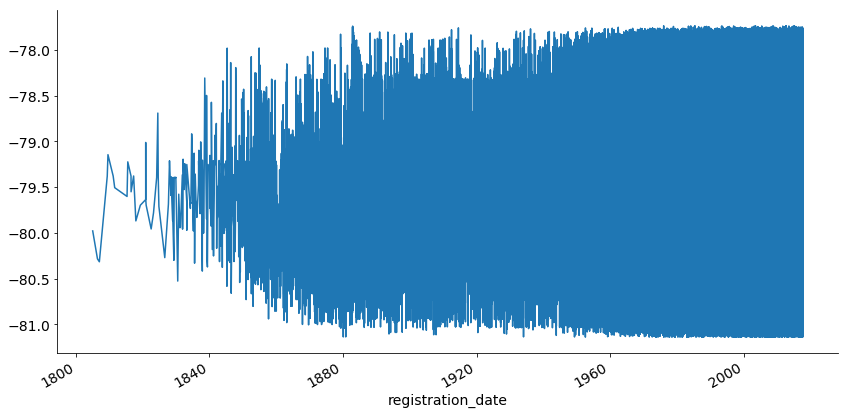

In [207]:
data.x.plot()

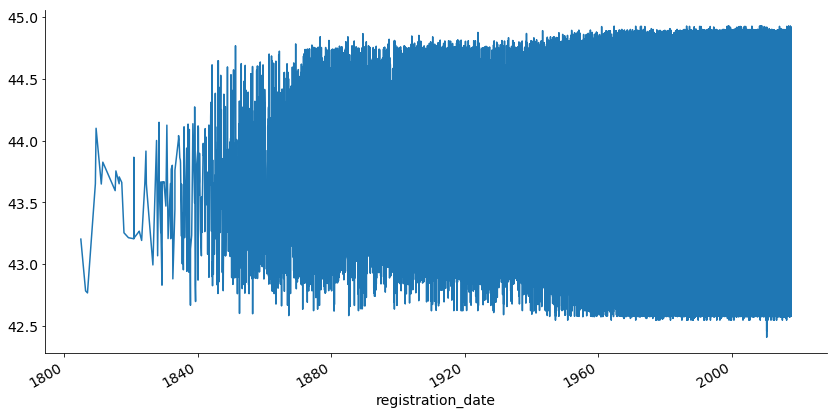

In [208]:
data.y.plot()

#### Value counts for the column `'x'`:

In [209]:
data['x'].value_counts()

-79.413760    7590
-79.384130    7556
-79.250519    7545
-79.245694    7510
-79.405482    7240
-79.635285    7121
-79.391576    7022
-79.413501    7005
-79.536251    6415
-79.376537    6160
-79.381384    5950
-79.394848    5833
-79.411866    5715
-79.529503    5274
-79.397139    4861
-79.393519    4626
-79.219692    4553
-79.293850    4501
-79.375769    4275
-79.490778    4190
-79.420176    4113
-79.369434    4077
-79.261898    4067
-79.359209    4062
-79.615963    3986
-79.415177    3952
-79.379115    3944
-79.558760    3881
-79.340619    3875
-79.414085    3809
              ... 
-80.246732       1
-79.706907       1
-79.439724       1
-79.247392       1
-79.435085       1
-80.436318       1
-79.288979       1
-79.889756       1
-79.853224       1
-79.399245       1
-79.570944       1
-79.283715       1
-79.568879       1
-79.459083       1
-79.408602       1
-79.530606       1
-79.297834       1
-79.472143       1
-79.779320       1
-79.206645       1
-80.614120       1
-79.703132  

#### Value counts for the column `'y'`

In [210]:
data['y'].value_counts()

43.776163    7590
43.660260    7556
43.780865    7545
43.781802    7510
43.636816    7240
43.595254    7121
43.639941    7022
43.765743    7005
43.638889    6415
43.643017    6160
43.640071    5950
43.640700    5833
43.768577    5715
43.644594    5274
43.640304    4861
43.639754    4626
43.177712    4553
43.696321    4501
43.642228    4275
43.624289    4190
43.803483    4113
43.769364    4077
43.734381    4067
43.650124    4062
43.724804    3986
43.639640    3952
43.639718    3944
43.609297    3881
43.854205    3875
43.779449    3809
             ... 
43.714985       1
43.901402       1
44.325251       1
44.580913       1
43.984241       1
43.502227       1
44.517913       1
43.666909       1
43.570093       1
42.999402       1
43.861242       1
44.212197       1
44.122948       1
44.553509       1
43.753153       1
43.204194       1
43.400081       1
43.232083       1
43.487755       1
43.755622       1
43.986354       1
43.669160       1
44.501401       1
43.204015       1
43.873096 

No changes were made to `'x'` and `'y'`.
<a id='record_results'></a>
## 1.9 Recording results to a file

Back to the [top](#top) / [table of contents](#contents)

#### [Summary of the changes made to the original dataset](#top)

#### Recording results to file `'Data/HHSaleHistory_cleaned_v0.9.csv'`

In [211]:
data = data.drop('registration_date', axis=1)
data.to_csv('Data/HHSaleHistory_cleaned_v0.9.csv')
print("Results recorded to file 'HHSaleHistory_cleaned_v0.9.csv'!")

Results recorded to file 'HHSaleHistory_cleaned_v0.9.csv'!


#### Loading the new file for verification

In [212]:
data_check = pd.read_csv('Data/HHSaleHistory_cleaned_v0.9.csv')
print("File 'HHSaleHistory_cleaned_v0.9.csv' loaded into the data frame 'data_check'!")

File 'HHSaleHistory_cleaned_v0.9.csv' loaded into the data frame 'data_check'!


### New file `'Data/HHSaleHistory_cleaned_v0.9.csv'`

#### Top 5 rows

In [213]:
data_check.head()

,registration_date,row_num,decade,year,lro_num,pin,consideration_amt,postal_code,province,unitno,street_name,street_designation,street_direction,municipality,street_suffix,street_number,x,y
0,1805-01-06,0,180,1805,62,174140492,NaN,NaN,ON,NaN,NaN,NaN,NaN,Hamilton,NaN,NaN,-79.977420,43.203291
1,1806-06-10,1,180,1806,37,502090167,NaN,NaN,ON,NaN,Highway 24,NaN,NaN,Woodhouse/Port Dover,NaN,2164.0,-80.282483,42.784625
2,1807-01-03,2,180,1807,37,501980307,NaN,NaN,ON,NaN,Char'Ville Rd 4,NaN,NaN,Vittoria,NaN,1661.0,-80.314465,42.768204
3,1809-05-16,3,180,1809,80,214030087,NaN,NaN,ON,NaN,NaN,NaN,NaN,Toronto,NaN,NaN,-79.379395,43.651264
4,1809-08-02,4,180,1809,40,268370013,NaN,L9P1R2,ON,NaN,6Th,Conc,NaN,Uxbridge,NaN,6800.0,-79.144210,44.099980


#### Summary information

In [214]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8226103 entries, 1805-01-06 to 2017-10-11
Data columns (total 17 columns):
row_num               8226103 non-null int32
decade                8226103 non-null int32
year                  8226103 non-null int32
lro_num               8226103 non-null int64
pin                   8226103 non-null int64
consideration_amt     6247858 non-null float64
postal_code           7101946 non-null object
province              8226103 non-null object
unitno                1489665 non-null float64
street_name           7847438 non-null object
street_designation    7108227 non-null object
street_direction      674992 non-null object
municipality          8196113 non-null object
street_suffix         166 non-null float64
street_number         7841470 non-null float64
x                     8216524 non-null float64
y                     8216524 non-null float64
dtypes: float64(6), int32(3), int64(2), object(6)
memory usage: 1.2+ GB


#### `'consideration_amt'` statistics

In [215]:
data.consideration_amt.describe()

count    6.247858e+06
mean     5.633393e+05
std      1.900839e+08
min      3.100000e+01
25%      1.530000e+05
50%      2.399790e+05
75%      3.720000e+05
max      4.477478e+11
Name: consideration_amt, dtype: float64

In [216]:
print('All scripts were run!')

All scripts were run!


<a id='references'></a>
## 1.10 References

Back to the [top](#top) / [contents](#contents)


<a id='codd_1990'></a>
[Codd, E. F. The relational model for database management : version 2.](https://search.library.utoronto.ca/details?1917145)  Reading, Mass: Addison-Wesley, 1990. Print.

<a id='wickham_2014'></a>
[Wickham, Hadley. (2014). Tidy data.](https://www.researchgate.net/publication/215990669_Tidy_data) The American Statistician. 14. 10.18637/jss.v059.i10. 